# Prepare Notebook

In [13]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

def warn(*args, **kwargs):
    pass
warnings.warn = warn

import numpy as np
import os

from pprint import PrettyPrinter

pp = PrettyPrinter(indent=4)

In [14]:
import sys

sys.path.append("../")

In [15]:
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=False)

In [16]:
from IPython.core.magic import register_cell_magic

@register_cell_magic
def run(line, cell):
    try:
        exec(cell)
    except Exception as e:
        pass

In [17]:
from evaluation.evaluate import evaluate_model, print_eval, plot_diff_train_size_f1
from evaluation.evaluate import CustomGridSearchCV
from sampling.sampling import loc, oversampling_adasyn, oversampling_smote, loc_oversampling_adasyn, loc_oversampling_smote

# Merge Datasets

In [6]:
import os

dataset_path = "../../datasets/features/"

content = np.load(os.path.join(dataset_path, "content.npz"))
fake_follower = np.load(os.path.join(dataset_path, "fake_follower.npz"))
feed = np.load(os.path.join(dataset_path, "feed.npz"))
game = np.load(os.path.join(dataset_path, "game.npz"))
human = np.load(os.path.join(dataset_path, "human.npz"))
political = np.load(os.path.join(dataset_path, "political.npz"))
service = np.load(os.path.join(dataset_path, "service.npz"))
social_spam = np.load(os.path.join(dataset_path, "social_spam.npz"))
stock = np.load(os.path.join(dataset_path, "stock.npz"))
traditional_spam = np.load(os.path.join(dataset_path, "traditional_spam.npz"))

In [7]:
X = np.concatenate((content["features"],
    fake_follower["features"],
    feed["features"],
    game["features"],
    human["features"],
    political["features"],
    service["features"],
    social_spam["features"],
    stock["features"],
    traditional_spam["features"]), axis=0)

In [8]:
ids = np.concatenate((content["ids"],
    fake_follower["ids"],
    feed["ids"],
    game["ids"],
    human["ids"],
    political["ids"],
    service["ids"],
    social_spam["ids"],
    stock["ids"],
    traditional_spam["ids"]), axis=0)

In [9]:
y = np.concatenate((np.full(content["ids"].shape, 0),
    np.full(fake_follower["ids"].shape, 1),
    np.full(feed["ids"].shape, 2),
    np.full(game["ids"].shape, 3),
    np.full(human["ids"].shape, 4),
    np.full(political["ids"].shape, 5),
    np.full(service["ids"].shape, 6),
    np.full(social_spam["ids"].shape, 7),
    np.full(stock["ids"].shape, 8),
    np.full(traditional_spam["ids"].shape, 9),), axis=0)

In [10]:
np.savez_compressed("twitter_bot_dataset_features", X=X, y=y, ids=ids)

In [11]:
np.savez_compressed("twitter_bot_dataset_features_preprocessed", X=X, y=y, ids=ids)

# Load datasets

In [6]:
dataset_path = "../../datasets/features/"

dataset = np.load(os.path.join(dataset_path, "twitter_bot_dataset_features.npz"))
X = dataset["X"]
y = dataset["y"]
ids = dataset["ids"]

In [7]:
X.shape

(35588, 105)

In [8]:
classes, classes_freq = np.unique(y, return_counts=True)
list(zip(classes, classes_freq))

[(0, 1083),
 (1, 825),
 (2, 815),
 (3, 80),
 (4, 18431),
 (5, 335),
 (6, 270),
 (7, 4215),
 (8, 7127),
 (9, 2407)]

## Prepare datasets

In [1]:
label_names = [
    "content",
    "fake_follower",
    "feed",
    "game",
    "human",
    "political",
    "service",
    "social_spam",
    "stock",
    "traditional_spam",
]
labels = list(range(len(label_names)))

Remove nan samples

In [10]:
nan_samples = np.isnan(X).any(axis=1)

X = X[~nan_samples]
y = y[~nan_samples]
ids = ids[~nan_samples]

In [11]:
X.shape

(31944, 105)

Dataset distribution after filtering nan values

In [12]:
classes, classes_freq = np.unique(y, return_counts=True)
list(zip(label_names, classes_freq))

[('content', 1083),
 ('fake_follower', 638),
 ('feed', 815),
 ('game', 80),
 ('human', 15508),
 ('political', 335),
 ('service', 270),
 ('social_spam', 4150),
 ('stock', 6976),
 ('traditional_spam', 2089)]

### One hot encode the categorical values

In [13]:
from sklearn.preprocessing import OneHotEncoder
from features.user import USER_FEATURES_INDEX

user_features_index = [f for f, i in sorted(USER_FEATURES_INDEX.items(), key=lambda feature: feature[1])]
    
one_hot_enc_countries = OneHotEncoder(categories=[list(range(251))])
countries_one_hot_enc = one_hot_enc_countries.fit_transform(X[:, user_features_index.index("country_with_most_tweets")].reshape(-1,1))
    
one_hot_enc_sources = OneHotEncoder(categories=[list(range(1,18))])
sources_one_hot_enc = one_hot_enc_sources.fit_transform(X[:, user_features_index.index("most_used_source")].reshape(-1,1))
    
one_hot_enc_coord_groups = OneHotEncoder(categories=[list(range(-1,11))])
coord_groups_one_hot_enc = one_hot_enc_coord_groups.fit_transform(X[:, user_features_index.index("most_frequent_tweet_coord_group")].reshape(-1,1))

one_hot_enc_tweet_languages = OneHotEncoder(categories=[list(range(189))])
tweet_languages_one_hot_enc = one_hot_enc_tweet_languages.fit_transform(X[:, user_features_index.index("most_used_tweet_language")].reshape(-1,1))

one_hot_enc_username_structures = OneHotEncoder(categories=[list(range(-1,14))])
username_structures_one_hot_enc = one_hot_enc_username_structures.fit_transform(X[:, user_features_index.index("username_structure")].reshape(-1,1))

one_hot_enc_url_other_service_profile = OneHotEncoder(categories=[list(range(13))])
url_other_service_profile_one_hot_enc = one_hot_enc_url_other_service_profile.fit_transform(X[:, user_features_index.index("profile_url_to_other_service_profile")].reshape(-1,1))

del_elems = [
    user_features_index.index("country_with_most_tweets"),
    user_features_index.index("most_used_source"),
    user_features_index.index("most_frequent_tweet_coord_group"),
    user_features_index.index("most_used_tweet_language"),
    user_features_index.index("username_structure"),
    user_features_index.index("profile_url_to_other_service_profile")
]

user_features_index = [name for i, name in enumerate(user_features_index) if i not in del_elems]

X = np.delete(X, del_elems, axis=1).reshape((-1, X.shape[1]-len(del_elems)))

binary_features = [
    "description_url_contains_username",
    "description_url_contains_name",
    "description_contains_bot",
    "username_contains_name",
    "username_contains_bot",
    "name_contains_bot",
    "profile_url_domain_contains_username",
    "profile_url_domain_contains_name",
    "profile_url_path_contains_username",
    "profile_url_path_contains_name",
    "default_profile_img",
    "default_profile_background",
    "protected",
    "verified",
    "account_location_provided"
]

continous_features = [f_name for f_name in user_features_index if f_name not in binary_features]

X = np.c_[
    X,
    countries_one_hot_enc.toarray(), # 251
    sources_one_hot_enc.toarray(), # 17
    coord_groups_one_hot_enc.toarray(), # 12
    tweet_languages_one_hot_enc.toarray(), # 189
    username_structures_one_hot_enc.toarray(), # 15
    url_other_service_profile_one_hot_enc.toarray(), # 15
]

user_features_index += ["tweet countries one hot encoded {}".format(i) for i in range(251)]
user_features_index += ["tweet sources one hot encoded {}".format(i) for i in range(17)]
user_features_index += ["tweet coord groups one hot encoded {}".format(i) for i in range(12)]
user_features_index += ["tweet language one hot encoded {}".format(i) for i in range(189)]
user_features_index += ["username one hot encoded {}".format(i) for i in range(15)]
user_features_index += ["url to other service profile one hot encoded {}".format(i) for i in range(15)]

print("Shape after one hot encoding: {}".format(X.shape))

Shape after one hot encoding: (31944, 596)


Remove features with variance == 0

In [14]:
from sklearn.feature_selection import VarianceThreshold
from itertools import compress

vt = VarianceThreshold()
vt.fit(X)
var_threshold_mask = vt.get_support()
X = X[:,var_threshold_mask]

for i, v in enumerate(var_threshold_mask):
    if not v:
        print(i, user_features_index[i])

user_features_index = list(compress(user_features_index, var_threshold_mask))
continous_features = [f_name for f_name in continous_features if f_name in user_features_index]
continous_features_idx = [user_features_index.index(f_name) for f_name in continous_features]

print("Shape after removing features with variance 0: {}".format(X.shape))

100 tweet countries one hot encoded 1
101 tweet countries one hot encoded 2
102 tweet countries one hot encoded 3
103 tweet countries one hot encoded 4
104 tweet countries one hot encoded 5
105 tweet countries one hot encoded 6
106 tweet countries one hot encoded 7
107 tweet countries one hot encoded 8
108 tweet countries one hot encoded 9
110 tweet countries one hot encoded 11
113 tweet countries one hot encoded 14
114 tweet countries one hot encoded 15
115 tweet countries one hot encoded 16
116 tweet countries one hot encoded 17
117 tweet countries one hot encoded 18
119 tweet countries one hot encoded 20
120 tweet countries one hot encoded 21
121 tweet countries one hot encoded 22
122 tweet countries one hot encoded 23
123 tweet countries one hot encoded 24
124 tweet countries one hot encoded 25
125 tweet countries one hot encoded 26
126 tweet countries one hot encoded 27
127 tweet countries one hot encoded 28
128 tweet countries one hot encoded 29
129 tweet countries one hot encode

# Dataset exploration

## Plots

In [ ]:
import plotly.graph_objects as go
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X_3d = PCA(n_components=3).fit_transform(StandardScaler().fit_transform(X))

plot_data = []
for l in labels:
    Xs = X_3d[y==l]
    plot_data.append(go.Scatter3d(x=Xs[:,0], y=Xs[:,1], z=Xs[:,2], mode="markers", name=label_names[l]))

fig = go.Figure(data=plot_data)
iplot(fig)

In [ ]:
import plotly.graph_objects as go
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X_3d = PCA(n_components=2).fit_transform(StandardScaler().fit_transform(X))

plot_data = []
for l in labels:
    Xs = X_3d[y==l]
    plot_data.append(go.Scattergl(x=Xs[:,0], y=Xs[:,1], mode="markers", name=label_names[l]))

fig = go.Figure(data=plot_data)
iplot(fig)

## Tables

In [ ]:
import qgrid
import pandas as pd
df = pd.DataFrame(np.c_[y, X])
col_names = ["label"]
col_names += ["{} {}".format(i, name) for i, name in enumerate(USER_FEATURES_INDEX)]
# df.columns = col_names
qgrid.show_grid(df,
                grid_options={
                    'forceFitColumns': False,
                    'defaultColumnWidth': 100
                })

# Classification

## Baseline: Logistic Regression

Best Model:
- Standard Scalar
- F1 Score: 0.771
- ROC AUC: 0.978
- Bot AUC: 0.955
- Bot type AUC: 0.949
- LOG LOSS: 0.252

### Basic

no additional preprocessing

one vs rest schema:

F1 Score (macro): 0.300
ROC AUC (macro): 0.923
Human Bot AUC: 0.940
Bot type AUC (macro): 0.942
LOG LOSS (mean): 0.835
content
	F1 Score (mean): 0.304
	ROC AUC (mean): 0.970
fake_follower
	F1 Score (mean): 0.160
	ROC AUC (mean): 0.901
feed
	F1 Score (mean): 0.192
	ROC AUC (mean): 0.907
game
	F1 Score (mean): 0.000
	ROC AUC (mean): 0.915
human
	F1 Score (mean): 0.794
	ROC AUC (mean): 0.940
political
	F1 Score (mean): 0.102
	ROC AUC (mean): 0.954
service
	F1 Score (mean): 0.007
	ROC AUC (mean): 0.887
social_spam
	F1 Score (mean): 0.513
	ROC AUC (mean): 0.956
stock
	F1 Score (mean): 0.871
	ROC AUC (mean): 0.978
traditional_spam
	F1 Score (mean): 0.060
	ROC AUC (mean): 0.822


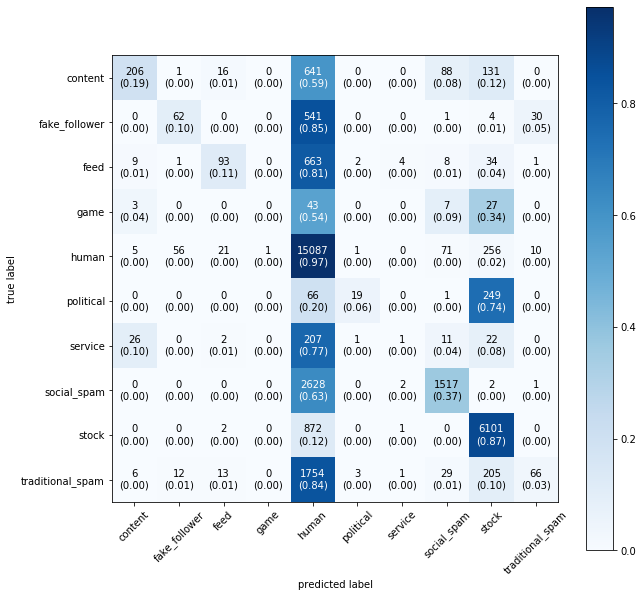

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = LogisticRegression(solver="lbfgs",
                         max_iter=1000,
                         multi_class="ovr",
                         random_state=42,
                         n_jobs=os.cpu_count())

pipeline = Pipeline([("clf", clf)])

eval_scores = evaluate_model(pipeline, X, y, label_names, calc_log_loss=True)
print_eval(eval_scores, label_names, console_confm_print=False)

### Data scaling

#### Standard Scaler

F1 Score (macro): 0.771
ROC AUC (macro): 0.978
Human Bot AUC: 0.988
Bot type AUC (macro): 0.990
LOG LOSS (mean): 0.252
content
	F1 Score (mean): 0.876
	ROC AUC (mean): 0.996
fake_follower
	F1 Score (mean): 0.617
	ROC AUC (mean): 0.963
feed
	F1 Score (mean): 0.786
	ROC AUC (mean): 0.991
game
	F1 Score (mean): 0.314
	ROC AUC (mean): 0.922
human
	F1 Score (mean): 0.955
	ROC AUC (mean): 0.988
political
	F1 Score (mean): 0.934
	ROC AUC (mean): 0.995
service
	F1 Score (mean): 0.438
	ROC AUC (mean): 0.959
social_spam
	F1 Score (mean): 0.976
	ROC AUC (mean): 0.996
stock
	F1 Score (mean): 0.978
	ROC AUC (mean): 0.997
traditional_spam
	F1 Score (mean): 0.838
	ROC AUC (mean): 0.972


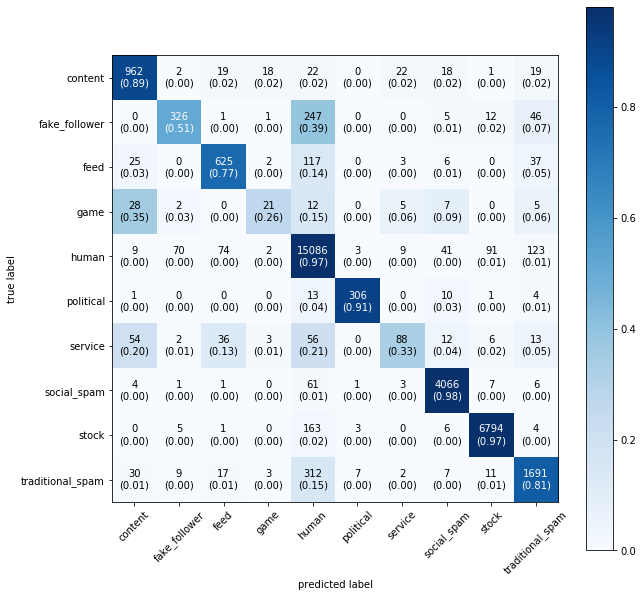

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

clf = LogisticRegression(solver="lbfgs",
                         max_iter=1000,
                         multi_class="ovr",
                         random_state=42,
                         n_jobs=os.cpu_count())

pipeline = Pipeline([("scaling", StandardScaler()), ("clf", clf)])

eval_scores = evaluate_model(pipeline, X, y, label_names, calc_log_loss=True)
print_eval(eval_scores, label_names, console_confm_print=False)

#### min max scaling

F1 Score (macro): 0.732
ROC AUC (macro): 0.983
Human Bot AUC: 0.987
Bot type AUC (macro): 0.989
LOG LOSS (mean): 0.261
content
	F1 Score (mean): 0.864
	ROC AUC (mean): 0.996
fake_follower
	F1 Score (mean): 0.558
	ROC AUC (mean): 0.957
feed
	F1 Score (mean): 0.720
	ROC AUC (mean): 0.992
game
	F1 Score (mean): 0.185
	ROC AUC (mean): 0.960
human
	F1 Score (mean): 0.952
	ROC AUC (mean): 0.987
political
	F1 Score (mean): 0.931
	ROC AUC (mean): 0.997
service
	F1 Score (mean): 0.352
	ROC AUC (mean): 0.971
social_spam
	F1 Score (mean): 0.964
	ROC AUC (mean): 0.996
stock
	F1 Score (mean): 0.977
	ROC AUC (mean): 0.997
traditional_spam
	F1 Score (mean): 0.816
	ROC AUC (mean): 0.972


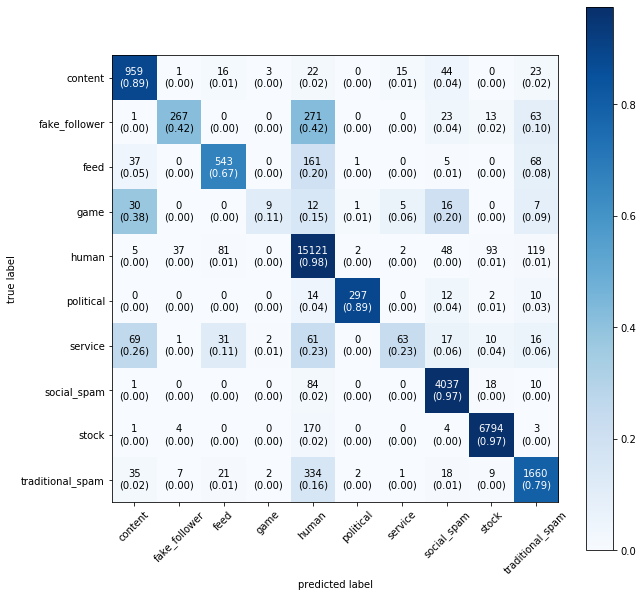

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

clf = LogisticRegression(solver="lbfgs",
                         max_iter=1000,
                         multi_class="ovr",
                         random_state=42,
                         n_jobs=os.cpu_count())
        
pipeline = Pipeline([("scaling", MinMaxScaler()), ("clf", clf)])

eval_scores = evaluate_model(pipeline, X, y, label_names, calc_log_loss=True)
print_eval(eval_scores, label_names, console_confm_print=False)

### different train sizes

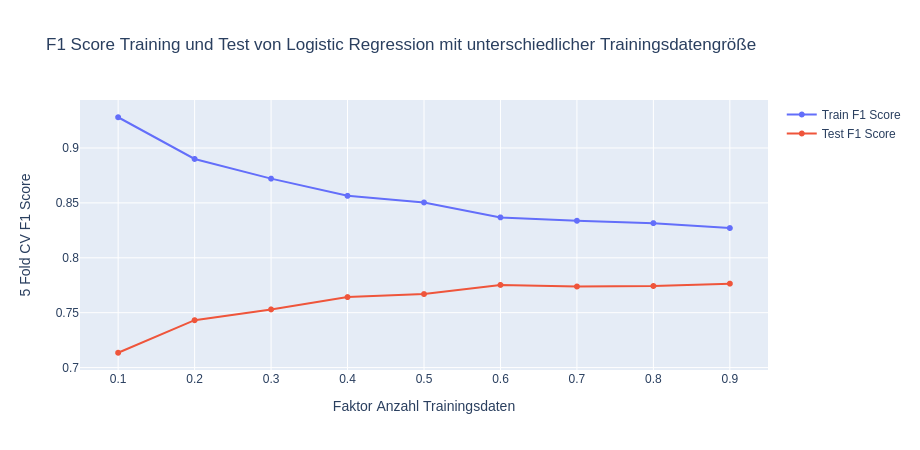

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

clf = LogisticRegression(solver="lbfgs",
                         max_iter=1000,
                         multi_class="ovr",
                         n_jobs=os.cpu_count())

pipeline = Pipeline([("scaling", StandardScaler()), ("clf", clf)])

plot_diff_train_size_f1(pipeline, X, y, "Logistic Regression")

## KNN

Best Model:
- SMOTE + Standard Scalar
- F1 Score: 0.779
- ROC AUC: 0.904
- Bot AUC: 0.948
- Bot type AUC: 0.944

### Basic

Grid Search on basic KNN

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

clf = KNeighborsClassifier(metric="euclidian", n_jobs=os.cpu_count())
pipeline = Pipeline([("clf", clf)])

param_grid = {
    "clf__n_neighbors": range(1,30)
}

scoring = ["f1_macro"]

gs = GridSearchCV(pipeline, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), n_jobs=os.cpu_count(), param_grid=param_grid, scoring=scoring, refit="f1_macro")
gs.fit(X,y)

pp.pprint(gs.cv_results_)
pp.pprint(gs.best_params_)
pp.pprint(gs.best_score_)

- k: 4
- f1: 0.544

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

clf = KNeighborsClassifier(metric="manhattan", n_jobs=os.cpu_count())
pipeline = Pipeline([("clf", clf)])

param_grid = {
    "clf__n_neighbors": range(1,30)
}

scoring = ["f1_macro"]

gs = GridSearchCV(pipeline, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), n_jobs=os.cpu_count(), param_grid=param_grid, scoring=scoring, refit="f1_macro")
gs.fit(X,y)

pp.pprint(gs.cv_results_)
pp.pprint(gs.best_params_)
pp.pprint(gs.best_score_)

- k: 4
- f1: 0.562

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

clf = KNeighborsClassifier(metric="minkowski", p=3, n_jobs=os.cpu_count())
pipeline = Pipeline([("clf", clf)])

param_grid = {
    "clf__n_neighbors": range(1,30)
}

scoring = ["f1_macro"]

gs = GridSearchCV(pipeline, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), n_jobs=os.cpu_count(), param_grid=param_grid, scoring=scoring, refit="f1_macro")
gs.fit(X,y)

pp.pprint(gs.cv_results_)
pp.pprint(gs.best_params_)
pp.pprint(gs.best_score_)

- k: 4
- f1: 0.533

best:
- k: 4
- dist metric: manhattan

F1 Score (macro): 0.562
ROC AUC (macro): 0.833
Human Bot AUC: 0.934
Bot type AUC (macro): 0.926
content
	F1 Score (mean): 0.696
	ROC AUC (mean): 0.909
fake_follower
	F1 Score (mean): 0.301
	ROC AUC (mean): 0.764
feed
	F1 Score (mean): 0.464
	ROC AUC (mean): 0.813
game
	F1 Score (mean): 0.018
	ROC AUC (mean): 0.602
human
	F1 Score (mean): 0.875
	ROC AUC (mean): 0.934
political
	F1 Score (mean): 0.559
	ROC AUC (mean): 0.824
service
	F1 Score (mean): 0.257
	ROC AUC (mean): 0.667
social_spam
	F1 Score (mean): 0.924
	ROC AUC (mean): 0.976
stock
	F1 Score (mean): 0.910
	ROC AUC (mean): 0.967
traditional_spam
	F1 Score (mean): 0.616
	ROC AUC (mean): 0.871


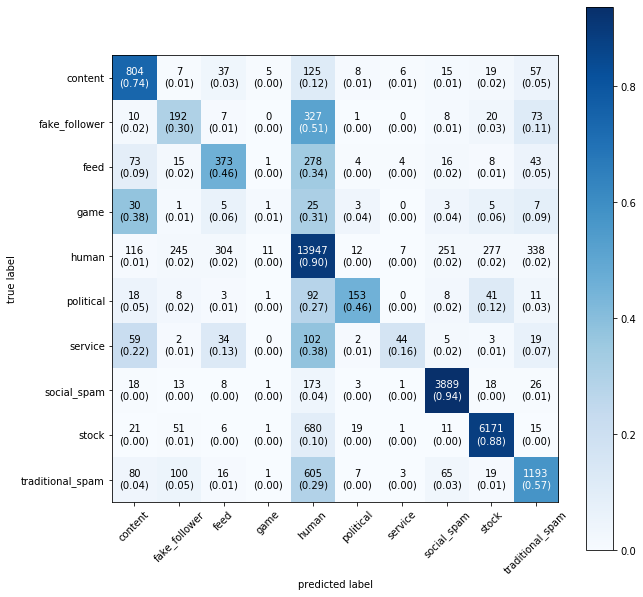

In [18]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

clf = KNeighborsClassifier(n_neighbors=4, metric="manhattan", n_jobs=os.cpu_count())
pipeline = Pipeline([("clf", clf)])

eval_scores = evaluate_model(pipeline, X, y, label_names)
print_eval(eval_scores, label_names, console_confm_print=False)

### Data scaling

#### Standard Scaler

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

clf = KNeighborsClassifier(metric="manhattan", n_jobs=os.cpu_count())

pipeline = Pipeline([("scaling", StandardScaler()), ("clf", clf)])

estimator_params = {
    "clf__n_neighbors": list(range(1,10,1))
}

gs = CustomGridSearchCV(pipeline, estimator_params=estimator_params)
scores = gs.fit(X, y, label_names)
best_params_idx = np.argmax(scores["f1_scores"])
pp.pprint(scores["f1_scores"][best_params_idx])
pp.pprint(scores["params"][best_params_idx])
pp.pprint(scores["fold_scores"][best_params_idx])

best k=3

F1 Score (macro): 0.771
ROC AUC (macro): 0.904
Human Bot AUC: 0.972
Bot type AUC (macro): 0.968
content
	F1 Score (mean): 0.851
	ROC AUC (mean): 0.957
fake_follower
	F1 Score (mean): 0.582
	ROC AUC (mean): 0.838
feed
	F1 Score (mean): 0.806
	ROC AUC (mean): 0.940
game
	F1 Score (mean): 0.206
	ROC AUC (mean): 0.630
human
	F1 Score (mean): 0.948
	ROC AUC (mean): 0.972
political
	F1 Score (mean): 0.968
	ROC AUC (mean): 0.984
service
	F1 Score (mean): 0.526
	ROC AUC (mean): 0.794
social_spam
	F1 Score (mean): 0.977
	ROC AUC (mean): 0.992
stock
	F1 Score (mean): 0.976
	ROC AUC (mean): 0.988
traditional_spam
	F1 Score (mean): 0.875
	ROC AUC (mean): 0.947


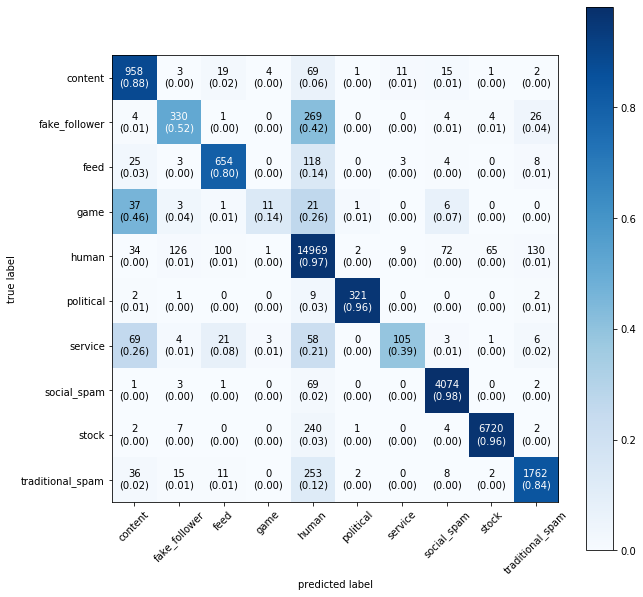

In [19]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

clf = KNeighborsClassifier(n_neighbors=3, metric="manhattan", n_jobs=os.cpu_count())
pipeline = Pipeline([("scaling", StandardScaler()), ("clf", clf)])

eval_scores = evaluate_model(pipeline, X, y, label_names)
print_eval(eval_scores, label_names, console_confm_print=False)

#### min max scaling

In [28]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

clf = KNeighborsClassifier(metric="manhattan", n_jobs=os.cpu_count())

pipeline = Pipeline([("scaling", MinMaxScaler()), ("clf", clf)])

estimator_params = {
    "clf__n_neighbors": list(range(1,20,1))
}

gs = CustomGridSearchCV(pipeline, estimator_params=estimator_params)
scores = gs.fit(X, y, label_names)
best_params_idx = np.argmax(scores["f1_scores"])
pp.pprint(scores["f1_scores"][best_params_idx])
pp.pprint(scores["params"][best_params_idx])
pp.pprint(scores["fold_scores"][best_params_idx])

Number of fits: 19
19/19 (avg 318.75s/job)0.7412578643909757
({'clf__n_neighbors': 3}, {})
{   'bot_aucs': [   0.9427140397558303,
                    0.9438096728752543,
                    0.9430270777899514,
                    0.9469400532164658,
                    0.9431747025673137],
    'bot_type_aucs': [   0.9373923931757708,
                         0.9400532164658006,
                         0.9386445453122554,
                         0.9420879636875881,
                         0.9386349405134627],
    'class_scores': {   'content': {   'f1_scores': [   0.8119266055045872,
                                                        0.8300220750551877,
                                                        0.8381374722838139,
                                                        0.8285077951002228,
                                                        0.8387096774193548],
                                       'roc_aucs': [   0.9262079228028468,
                          

Process GridSearchWatch-8:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "../evaluation/evaluate.py", line 274, in run
    worker_time = self.worker_times_q.get()
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 94, in get
    res = self._recv_bytes()
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt


best k=3

F1 Score (macro): 0.741
ROC AUC (macro): 0.891
Human Bot AUC: 0.969
Bot type AUC (macro): 0.964
content
	F1 Score (mean): 0.829
	ROC AUC (mean): 0.947
fake_follower
	F1 Score (mean): 0.555
	ROC AUC (mean): 0.817
feed
	F1 Score (mean): 0.759
	ROC AUC (mean): 0.927
game
	F1 Score (mean): 0.097
	ROC AUC (mean): 0.574
human
	F1 Score (mean): 0.943
	ROC AUC (mean): 0.969
political
	F1 Score (mean): 0.964
	ROC AUC (mean): 0.988
service
	F1 Score (mean): 0.462
	ROC AUC (mean): 0.771
social_spam
	F1 Score (mean): 0.972
	ROC AUC (mean): 0.991
stock
	F1 Score (mean): 0.977
	ROC AUC (mean): 0.988
traditional_spam
	F1 Score (mean): 0.853
	ROC AUC (mean): 0.939


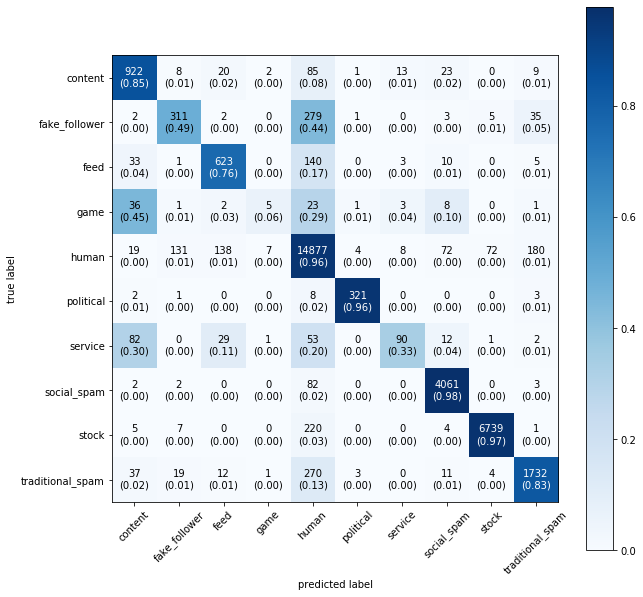

In [20]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

clf = KNeighborsClassifier(n_neighbors=3, metric="manhattan", n_jobs=os.cpu_count())
pipeline = Pipeline([("scaling", MinMaxScaler()), ("clf", clf)])

eval_scores = evaluate_model(pipeline, X, y, label_names)
print_eval(eval_scores, label_names, console_confm_print=False)

### Scaling + PCA

In [36]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

clf = KNeighborsClassifier(metric="manhattan", n_jobs=os.cpu_count())

        
pipeline = Pipeline([("scaling", StandardScaler()), ("pca", PCA()), ("clf", clf)])

param_grid = {
    "pca__n_components": range(30, 51, 1),
    "clf__n_neighbors": range(3, 6, 1)
}

scoring = ["f1_macro"]

gs = GridSearchCV(pipeline, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), n_jobs=os.cpu_count(), verbose=1, param_grid=param_grid, scoring=scoring, refit="f1_macro")
gs.fit(X,y)

#pp.pprint(gs.cv_results_)
pp.pprint(gs.best_params_)
pp.pprint(gs.best_score_)

Fitting 5 folds for each of 63 candidates, totalling 315 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:  3.3min
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed: 17.8min
[Parallel(n_jobs=6)]: Done 315 out of 315 | elapsed: 30.2min finished


{'clf__n_neighbors': 4, 'pca__n_components': 32}
0.7540701567575654


F1 Score (macro): 0.750
ROC AUC (macro): 0.911
Human Bot AUC: 0.972
Bot type AUC (macro): 0.970
content
	F1 Score (mean): 0.828
	ROC AUC (mean): 0.957
fake_follower
	F1 Score (mean): 0.548
	ROC AUC (mean): 0.848
feed
	F1 Score (mean): 0.751
	ROC AUC (mean): 0.939
game
	F1 Score (mean): 0.150
	ROC AUC (mean): 0.667
human
	F1 Score (mean): 0.941
	ROC AUC (mean): 0.972
political
	F1 Score (mean): 0.950
	ROC AUC (mean): 0.986
service
	F1 Score (mean): 0.526
	ROC AUC (mean): 0.813
social_spam
	F1 Score (mean): 0.978
	ROC AUC (mean): 0.991
stock
	F1 Score (mean): 0.973
	ROC AUC (mean): 0.988
traditional_spam
	F1 Score (mean): 0.853
	ROC AUC (mean): 0.945


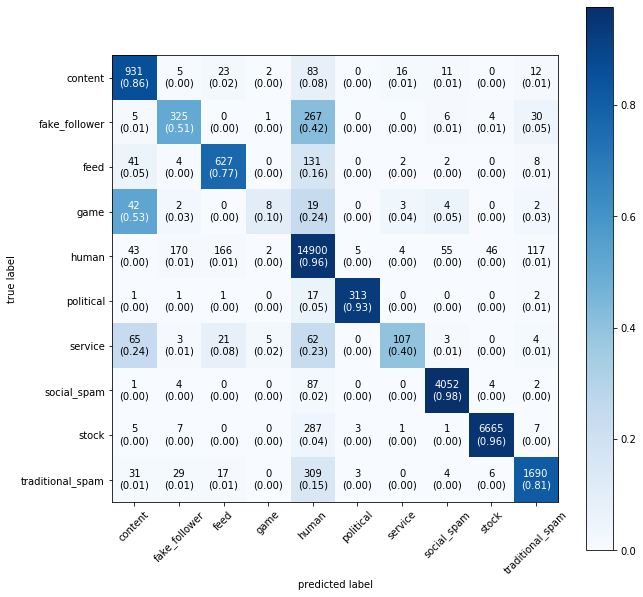

In [21]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

clf = KNeighborsClassifier(n_neighbors=4, metric="manhattan", n_jobs=os.cpu_count())
pipeline = Pipeline([("scaling", StandardScaler()), ("pca", PCA(n_components=32)), ("clf", clf)])

eval_scores = evaluate_model(pipeline, X, y, label_names)
print_eval(eval_scores, label_names, console_confm_print=False)

### oversampling game class

#### adasyn:

In [46]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

clf = KNeighborsClassifier(metric="manhattan", n_jobs=os.cpu_count())

pipeline = Pipeline([("scaling", StandardScaler()), ("clf", clf)])

estimator_params = {
    "clf__n_neighbors": range(4,5,1),
}

train_preproc_params = {
    "n_neighbors": range(7,8,1),
    "sampling_strategy": [{3:800}, {3:1000}, {3:1500}]
}

gs = CustomGridSearchCV(pipeline, estimator_params=estimator_params)
scores = gs.fit(X, y, label_names, train_preproc_func=oversampling_adasyn, train_preproc_params=train_preproc_params)
best_params_idx = np.argmax(scores["f1_scores"])
pp.pprint(scores["f1_scores"][best_params_idx])
pp.pprint(scores["params"][best_params_idx])
# pp.pprint(scores["fold_scores"][best_params_idx])

Number of fits: 3
3/3 (avg 181.36s/job)0.7775590669268171
({'clf__n_neighbors': 4}, {'n_neighbors': 7, 'sampling_strategy': {3: 800}})


Process GridSearchWatch-71:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "../evaluation/evaluate.py", line 274, in run
    worker_time = self.worker_times_q.get()
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 94, in get
    res = self._recv_bytes()
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt


best:
 - knn:
  - n_neighbors: 4
 - adasyn:
  - n_neighbors: 7
  - sampling_strategy: 3:800

F1 Score (macro): 0.778
ROC AUC (macro): 0.910
Human Bot AUC: 0.976
Bot type AUC (macro): 0.973
content
	F1 Score (mean): 0.850
	ROC AUC (mean): 0.960
fake_follower
	F1 Score (mean): 0.598
	ROC AUC (mean): 0.864
feed
	F1 Score (mean): 0.817
	ROC AUC (mean): 0.946
game
	F1 Score (mean): 0.264
	ROC AUC (mean): 0.636
human
	F1 Score (mean): 0.949
	ROC AUC (mean): 0.976
political
	F1 Score (mean): 0.971
	ROC AUC (mean): 0.985
service
	F1 Score (mean): 0.494
	ROC AUC (mean): 0.803
social_spam
	F1 Score (mean): 0.976
	ROC AUC (mean): 0.992
stock
	F1 Score (mean): 0.977
	ROC AUC (mean): 0.990
traditional_spam
	F1 Score (mean): 0.879
	ROC AUC (mean): 0.951


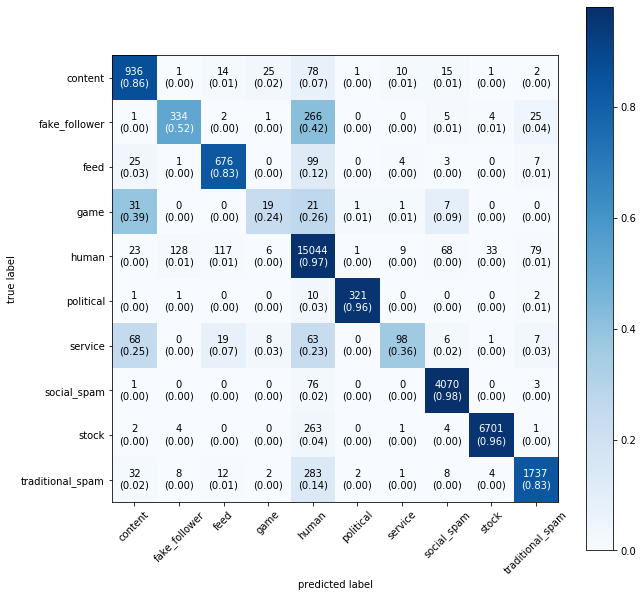

In [22]:
from sklearn.neighbors import KNeighborsClassifier
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import ADASYN

clf = KNeighborsClassifier(n_neighbors=4, metric="manhattan", n_jobs=os.cpu_count())

adasyn = ADASYN(sampling_strategy={3:800}, n_neighbors=7, random_state=42, n_jobs=os.cpu_count())

pipeline = Pipeline([("adasyn", adasyn), ("scaling", StandardScaler()), ("clf", clf)])

eval_scores = evaluate_model(pipeline, X, y, label_names)
print_eval(eval_scores, label_names, console_confm_print=False)

#### smote:

In [50]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

clf = KNeighborsClassifier(metric="manhattan", n_jobs=os.cpu_count())

pipeline = Pipeline([("scaling", StandardScaler()), ("clf", clf)])

estimator_params = {
    "clf__n_neighbors": list(range(1,5,1)),
}

train_preproc_params = {
    "k_neighbors": list(range(50,55,1)),
    "sampling_strategy": [{3:800}]
}

gs = CustomGridSearchCV(pipeline, estimator_params=estimator_params)
scores = gs.fit(X, y, label_names, train_preproc_func=oversampling_smote, train_preproc_params=train_preproc_params)
best_params_idx = np.argmax(scores["f1_scores"])
pp.pprint(scores["f1_scores"][best_params_idx])
pp.pprint(scores["params"][best_params_idx])
pp.pprint(scores["fold_scores"][best_params_idx])

Number of fits: 20
20/20 (avg 415.63s/job)0.7787750715029984
({'clf__n_neighbors': 3}, {'k_neighbors': 52, 'sampling_strategy': {3: 800}})
{   'bot_aucs': [   0.9475661292847081,
                    0.9485052433870715,
                    0.9496008765064955,
                    0.9488182814211926,
                    0.9470882905447714],
    'bot_type_aucs': [   0.9422444827046487,
                         0.9449053059946784,
                         0.9463139771482235,
                         0.9449053059946784,
                         0.9441139636819036],
    'class_scores': {   'content': {   'f1_scores': [   0.8213457076566125,
                                                        0.8668171557562077,
                                                        0.8571428571428571,
                                                        0.8340611353711791,
                                                        0.8662131519274376],
                                       'roc_aucs': [ 

best:
 - knn:
  - n_neighbors: 3
 - smote:
  - k_neighbors: 52
  - sampling_strategy: 3:800

F1 Score (macro): 0.779
ROC AUC (macro): 0.904
Human Bot AUC: 0.972
Bot type AUC (macro): 0.969
content
	F1 Score (mean): 0.849
	ROC AUC (mean): 0.953
fake_follower
	F1 Score (mean): 0.581
	ROC AUC (mean): 0.838
feed
	F1 Score (mean): 0.808
	ROC AUC (mean): 0.942
game
	F1 Score (mean): 0.277
	ROC AUC (mean): 0.636
human
	F1 Score (mean): 0.948
	ROC AUC (mean): 0.972
political
	F1 Score (mean): 0.968
	ROC AUC (mean): 0.984
service
	F1 Score (mean): 0.530
	ROC AUC (mean): 0.785
social_spam
	F1 Score (mean): 0.977
	ROC AUC (mean): 0.992
stock
	F1 Score (mean): 0.976
	ROC AUC (mean): 0.988
traditional_spam
	F1 Score (mean): 0.874
	ROC AUC (mean): 0.947


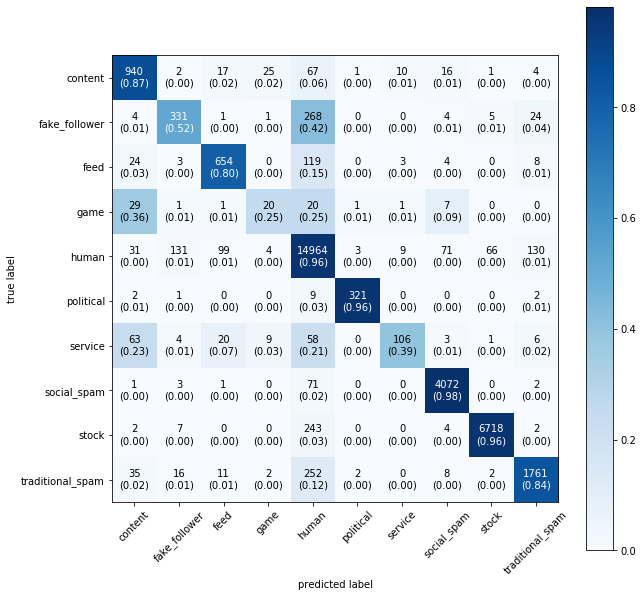

In [23]:
from sklearn.neighbors import KNeighborsClassifier
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

clf = KNeighborsClassifier(n_neighbors=3, metric="manhattan", n_jobs=os.cpu_count())

smote = SMOTE(sampling_strategy={3:800}, k_neighbors=52, random_state=42, n_jobs=os.cpu_count())

pipeline = Pipeline([("smote", smote), ("scaling", StandardScaler()), ("clf", clf)])

eval_scores = evaluate_model(pipeline, X, y, label_names)
print_eval(eval_scores, label_names, console_confm_print=False)

### different train sizes

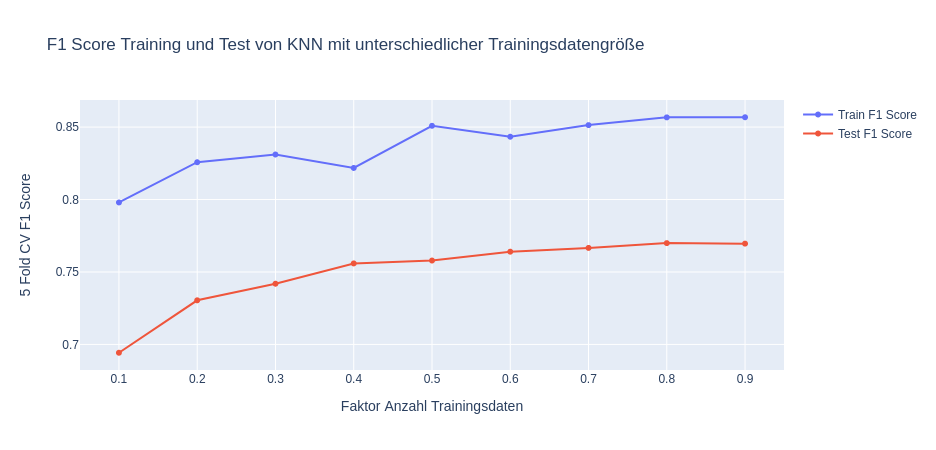

In [19]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

clf = KNeighborsClassifier(n_neighbors=3, metric="manhattan", n_jobs=os.cpu_count())

pipeline = Pipeline([("scaling", StandardScaler()), ("clf", clf)])

plot_diff_train_size_f1(pipeline, X, y, "KNN")

## BNB

Best Model:
- adasyn
- F1 Score: 0.667
- ROC AUC: 0.978
- Bot AUC: 0.892
- Bot type AUC: 0.882
- reducing dim with chi square does not help

### binning + var threshold

In [30]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import BernoulliNB
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import StratifiedKFold
from sklearn.compose import ColumnTransformer

clf = BernoulliNB()
pipeline = Pipeline([
    ("feature_binning", ColumnTransformer(
        transformers=[
            ("binning", KBinsDiscretizer(encode="onehot"), continous_features_idx)
        ],
        remainder="passthrough")),
    ("var_threshold", VarianceThreshold()),
    ("clf", clf)])
 
param_grid = {
    "feature_binning__binning__n_bins": range(1,50,1),
    "feature_binning__binning__strategy": ["quantile", "kmeans", "uniform"]
}

scoring = ["f1_macro"]

gs = GridSearchCV(pipeline, verbose=1, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), n_jobs=os.cpu_count(), param_grid=param_grid, scoring=scoring, refit="f1_macro")
gs.fit(X,y)

pp.pprint(gs.cv_results_)
pp.pprint(gs.best_params_)
pp.pprint(gs.best_score_)

Fitting 5 folds for each of 147 candidates, totalling 735 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:   11.9s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:  2.3min
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed:  9.8min
[Parallel(n_jobs=6)]: Done 735 out of 735 | elapsed: 23.7min finished
/home/infinityofspace/PycharmProjects/twitter-bot-classification/venv/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:197: UserWarning:

Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.

/home/infinityofspace/PycharmProjects/twitter-bot-classification/venv/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:197: UserWarning:

Bins whose width are too small (i.e., <= 1e-8) in feature 3 are removed. Consider decreasing the number of bins.

/home/infinityofspace/PycharmProjects/twitter-bot-classification/venv/lib/python3.6/site-packages/sklearn/preprocessing/_discret

{   'mean_fit_time': array([ 0.13272519,  0.11148605,  0.13296876,  1.24721999,  2.90989079,
        1.1479979 ,  1.5364224 ,  4.11520905,  1.38574719,  1.72006054,
        5.91586704,  2.63063226,  2.09464202,  7.09742093,  1.70072255,
        1.73900986,  8.8834023 ,  1.68930788,  1.79610538, 15.01344481,
        3.01260085,  2.19872065, 10.21690507,  1.02974949,  2.05529823,
       13.21009564,  1.11531758,  2.19070315, 14.31427183,  1.05180798,
        2.1336338 , 13.81614208,  1.01651354,  1.11884356, 15.26563606,
        1.0001492 ,  1.16828499, 17.18586111,  0.96294641,  1.18913693,
       18.42541556,  1.01710458,  1.22329302, 19.83929386,  0.98948874,
        1.19105268, 19.89973683,  0.95548511,  1.22793694, 23.77575879,
        1.01630058,  1.28325305, 25.47357221,  0.9675097 ,  1.14023404,
       26.02866421,  0.96447954,  1.24430084, 27.93615851,  0.99026308,
        1.21862764, 29.22771244,  1.03920856,  1.25707073, 29.90180755,
        1.0055656 ,  1.24997478, 31.8465860

F1 Score (macro): 0.657
ROC AUC (macro): 0.977
Human Bot AUC: 0.943
Bot type AUC (macro): 0.971
content
	F1 Score (mean): 0.818
	ROC AUC (mean): 0.994
fake_follower
	F1 Score (mean): 0.402
	ROC AUC (mean): 0.962
feed
	F1 Score (mean): 0.559
	ROC AUC (mean): 0.980
game
	F1 Score (mean): 0.194
	ROC AUC (mean): 0.957
human
	F1 Score (mean): 0.878
	ROC AUC (mean): 0.958
political
	F1 Score (mean): 0.848
	ROC AUC (mean): 0.995
service
	F1 Score (mean): 0.256
	ROC AUC (mean): 0.966
social_spam
	F1 Score (mean): 0.967
	ROC AUC (mean): 0.992
stock
	F1 Score (mean): 0.971
	ROC AUC (mean): 0.997
traditional_spam
	F1 Score (mean): 0.674
	ROC AUC (mean): 0.966


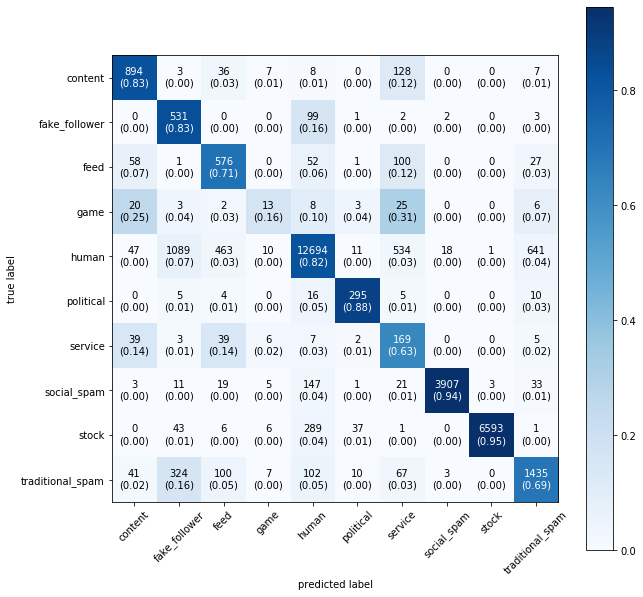

In [24]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import BernoulliNB
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.compose import ColumnTransformer

clf = BernoulliNB()

pipeline = Pipeline([
    ("feature_binning", ColumnTransformer(
        transformers=[
            ("binning", KBinsDiscretizer(encode="onehot", strategy="quantile", n_bins=35), continous_features_idx)
        ],
        remainder="passthrough")),
    ("var_threshold", VarianceThreshold()),
    ("clf", clf)])

eval_scores = evaluate_model(pipeline, X, y, label_names)
print_eval(eval_scores, label_names, console_confm_print=False)

### binning + var threshold + chi2

In [24]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import BernoulliNB
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import StratifiedKFold


clf = BernoulliNB()
pipeline = Pipeline([
    ("feature_binning", ColumnTransformer(
        transformers=[
            ("binning", KBinsDiscretizer(encode="onehot"), continous_features_idx)
        ],
        remainder="passthrough")),
    ("var_threshold", VarianceThreshold()),
    ('feature_selection', SelectKBest(score_func=chi2)),
    ("clf", clf)])
 
param_grid = {
    "feature_binning__binning__n_bins": range(1,5,1),
    "feature_binning__binning__strategy": ["quantile", "kmeans", "uniform"],
    "feature_selection__k": range(200,X.shape[1],1)
}

scoring = ["f1_macro"]

gs = GridSearchCV(pipeline, verbose=1, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), n_jobs=os.cpu_count(), param_grid=param_grid, scoring=scoring, refit="f1_macro")
gs.fit(X,y)

pp.pprint(gs.cv_results_)
pp.pprint(gs.best_params_)
pp.pprint(gs.best_score_)

Fitting 5 folds for each of 408 candidates, totalling 2040 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    2.6s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:    7.0s
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed:   13.9s
[Parallel(n_jobs=6)]: Done 788 tasks      | elapsed:  1.9min
[Parallel(n_jobs=6)]: Done 1238 tasks      | elapsed:  4.4min
[Parallel(n_jobs=6)]: Done 1788 tasks      | elapsed:  8.5min
[Parallel(n_jobs=6)]: Done 2040 out of 2040 | elapsed: 10.4min finished


{   'mean_fit_time': array([0.16264186, 0.17054434, 0.16087561, 0.16508617, 0.16651669,
       0.15204196, 0.16120968, 0.13566275, 0.14370828, 0.15894194,
       0.19264178, 0.15042095, 0.15375791, 0.16287065, 0.14232922,
       0.14712253, 0.14113507, 0.16487966, 0.15975161, 0.15819755,
       0.17709098, 0.15643492, 0.14764676, 0.15247746, 0.1505682 ,
       0.14583812, 0.13707719, 0.16137691, 0.16488919, 0.15628967,
       0.15528908, 0.16686597, 0.15308437, 0.16975222, 0.15941448,
       0.15558052, 0.14848256, 0.13436813, 0.14725227, 0.13562279,
       0.13641696, 0.12670226, 0.12765718, 0.14120946, 0.12963457,
       0.13103681, 0.13136711, 0.13508544, 0.13029766, 0.13382473,
       0.13824382, 0.14147019, 0.14247546, 0.14284244, 0.14133406,
       0.15683179, 0.15545707, 0.14134684, 0.1397202 , 0.14359794,
       0.13565793, 0.14831319, 0.15056372, 0.12897553, 0.12441382,
       0.13367414, 0.13848162, 0.16254067, 0.14954686, 0.14204087,
       0.17933679, 0.17542539, 0.1702209 

F1 Score (macro): 0.624
ROC AUC (macro): 0.967
Human Bot AUC: 0.969
Bot type AUC (macro): 0.971
content
	F1 Score (mean): 0.801
	ROC AUC (mean): 0.990
fake_follower
	F1 Score (mean): 0.337
	ROC AUC (mean): 0.928
feed
	F1 Score (mean): 0.501
	ROC AUC (mean): 0.970
game
	F1 Score (mean): 0.266
	ROC AUC (mean): 0.973
human
	F1 Score (mean): 0.867
	ROC AUC (mean): 0.969
political
	F1 Score (mean): 0.724
	ROC AUC (mean): 0.989
service
	F1 Score (mean): 0.307
	ROC AUC (mean): 0.925
social_spam
	F1 Score (mean): 0.938
	ROC AUC (mean): 0.990
stock
	F1 Score (mean): 0.966
	ROC AUC (mean): 0.996
traditional_spam
	F1 Score (mean): 0.530
	ROC AUC (mean): 0.945


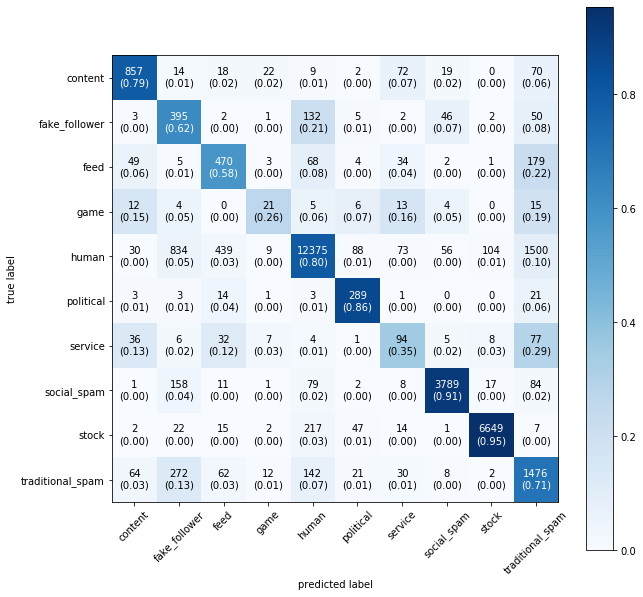

In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import BernoulliNB
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, chi2

clf = BernoulliNB()

pipeline = Pipeline([
    ("feature_binning", ColumnTransformer(
        transformers=[
            ("binning", KBinsDiscretizer(encode="onehot", strategy="uniform", n_bins=3), continous_features_idx)
        ],
        remainder="passthrough")),
    ("var_threshold", VarianceThreshold()),
    ("feature_selection", SelectKBest(chi2, k=217)),
    ("clf", clf)])

eval_scores = evaluate_model(pipeline, X, y, label_names)
print_eval(eval_scores, label_names, console_confm_print=False)

### custom binning

F1 Score (macro): 0.658
ROC AUC (macro): 0.978
Human Bot AUC: 0.942
Bot type AUC (macro): 0.971
content
	F1 Score (mean): 0.830
	ROC AUC (mean): 0.994
fake_follower
	F1 Score (mean): 0.411
	ROC AUC (mean): 0.964
feed
	F1 Score (mean): 0.573
	ROC AUC (mean): 0.981
game
	F1 Score (mean): 0.206
	ROC AUC (mean): 0.969
human
	F1 Score (mean): 0.877
	ROC AUC (mean): 0.957
political
	F1 Score (mean): 0.862
	ROC AUC (mean): 0.996
service
	F1 Score (mean): 0.238
	ROC AUC (mean): 0.966
social_spam
	F1 Score (mean): 0.954
	ROC AUC (mean): 0.993
stock
	F1 Score (mean): 0.972
	ROC AUC (mean): 0.997
traditional_spam
	F1 Score (mean): 0.655
	ROC AUC (mean): 0.965


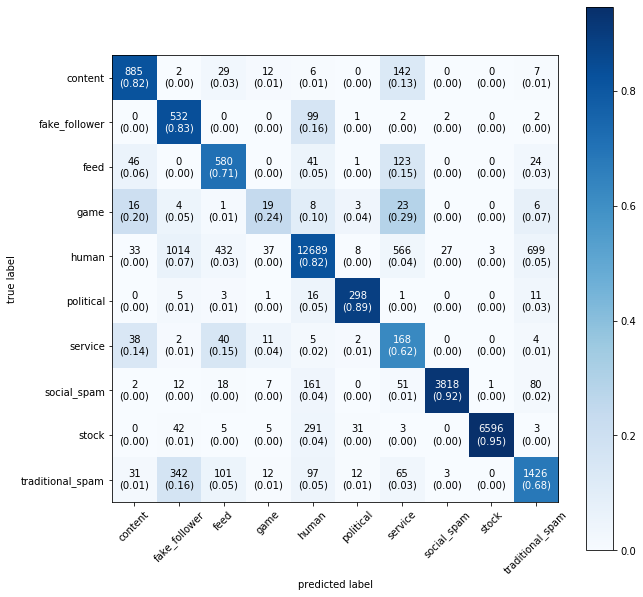

In [26]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import BernoulliNB
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.feature_selection import VarianceThreshold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder

percentiles = [
    99.9,
    95,
    90,
    85,
    80,
    75,
    70,
    65,
    60,
    55,
    50,
    45,
    40,
    35,
    30,
    25,
    20,
    15,
    10,
    5,
    0.01
]

def custom_column_transformer(X):
    X_new = np.empty_like(X)
    for i in range(X.shape[1]):
        bins = [np.percentile(X[:,i], p) for p in percentiles]
        binned = np.digitize(X[:,i], bins, right=False)
        X_new[:,i] = binned

    return X_new


clf = BernoulliNB()

ct = ColumnTransformer(
        transformers=[
            ("binning", FunctionTransformer(func=custom_column_transformer), continous_features_idx),
        ],
        remainder="passthrough",
        n_jobs=os.cpu_count())

X_new = ct.fit_transform(X)
X_new = OneHotEncoder(sparse=False).fit_transform(X_new)
X_new = VarianceThreshold().fit_transform(X_new)

eval_scores = evaluate_model(clf, X_new, y, label_names)
print_eval(eval_scores, label_names, console_confm_print=False)

### select k best chi square

F1 Score (macro): 0.321
ROC AUC (macro): 0.856
Human Bot AUC: 0.880
Bot type AUC (macro): 0.864
content
	F1 Score (mean): 0.176
	ROC AUC (mean): 0.820
fake_follower
	F1 Score (mean): 0.006
	ROC AUC (mean): 0.825
feed
	F1 Score (mean): 0.000
	ROC AUC (mean): 0.781
game
	F1 Score (mean): 0.000
	ROC AUC (mean): 0.830
human
	F1 Score (mean): 0.821
	ROC AUC (mean): 0.880
political
	F1 Score (mean): 0.000
	ROC AUC (mean): 0.766
service
	F1 Score (mean): 0.000
	ROC AUC (mean): 0.821
social_spam
	F1 Score (mean): 0.762
	ROC AUC (mean): 0.948
stock
	F1 Score (mean): 0.932
	ROC AUC (mean): 0.982
traditional_spam
	F1 Score (mean): 0.517
	ROC AUC (mean): 0.907


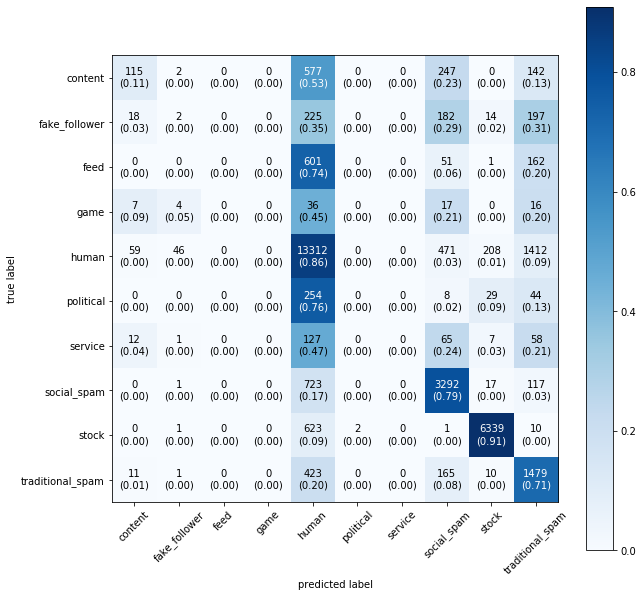

In [27]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import BernoulliNB
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.feature_selection import VarianceThreshold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder

percentiles = [
    99.9,
    95,
    90,
    85,
    80,
    75,
    70,
    65,
    60,
    55,
    50,
    45,
    40,
    35,
    30,
    25,
    20,
    15,
    10,
    5,
    0.01
]

def custom_column_transformer(X):
    X_new = np.empty_like(X)
    for i in range(X.shape[1]):
        bins = [np.percentile(X[:,i], p) for p in percentiles]
        binned = np.digitize(X[:,i], bins, right=False)
        X_new[:,i] = binned

    return X_new


clf = BernoulliNB()

ct = ColumnTransformer(
        transformers=[
            ("binning", FunctionTransformer(func=custom_column_transformer), continous_features_idx),
        ],
        remainder="passthrough",
        n_jobs=os.cpu_count())

X_new = ct.fit_transform(X)
X_new = OneHotEncoder(sparse=False).fit_transform(X_new)
X_new = VarianceThreshold().fit_transform(X_new)
X_new = SelectKBest(score_func=chi2).fit_transform(X_new, y)

eval_scores = evaluate_model(clf, X_new, y, label_names)
print_eval(eval_scores, label_names, console_confm_print=False)

### oversampling game class

#### adasyn

In [ ]:
from imblearn.pipeline import Pipeline
from sklearn.naive_bayes import BernoulliNB
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import ADASYN

clf = BernoulliNB()

pipeline = Pipeline([
    ("adasyn", ADASYN(random_state=42, n_jobs=os.cpu_count())),
    ("feature_binning", ColumnTransformer(
        transformers=[
            ("binning", KBinsDiscretizer(encode="onehot"), continous_features_idx)
        ],
        remainder="passthrough")),
    ("var_threshold", VarianceThreshold()),
    ("clf", clf)])

params = {
    "feature_binning__binning__n_bins": range(2,51,10),
    "feature_binning__binning__strategy": ["quantile", "kmeans", "uniform"],
    "adasyn__n_neighbors": range(1,61,10),
    "adasyn__sampling_strategy": [{3:250}, {3:500}, {3:800}]
}

gs = CustomGridSearchCV(pipeline, params=params)
scores = gs.fit(X, y, label_names)
best_params_idx = np.argmax(scores["f1_scores"])
pp.pprint(scores["f1_scores"][best_params_idx])
pp.pprint(scores["params"][best_params_idx])
# pp.pprint(scores["fold_scores"][best_params_idx])

best:
- bnb:
1. n bins: 55
2. strategy: kmeans
- adasyn:
1. k neigbors: 2
2. sampling strategy: 3:800

F1 Score (macro): 0.666
ROC AUC (macro): 0.977
Human Bot AUC: 0.945
Bot type AUC (macro): 0.971
content
	F1 Score (mean): 0.809
	ROC AUC (mean): 0.993
fake_follower
	F1 Score (mean): 0.428
	ROC AUC (mean): 0.962
feed
	F1 Score (mean): 0.599
	ROC AUC (mean): 0.982
game
	F1 Score (mean): 0.215
	ROC AUC (mean): 0.961
human
	F1 Score (mean): 0.877
	ROC AUC (mean): 0.959
political
	F1 Score (mean): 0.845
	ROC AUC (mean): 0.995
service
	F1 Score (mean): 0.331
	ROC AUC (mean): 0.967
social_spam
	F1 Score (mean): 0.939
	ROC AUC (mean): 0.991
stock
	F1 Score (mean): 0.971
	ROC AUC (mean): 0.997
traditional_spam
	F1 Score (mean): 0.641
	ROC AUC (mean): 0.965


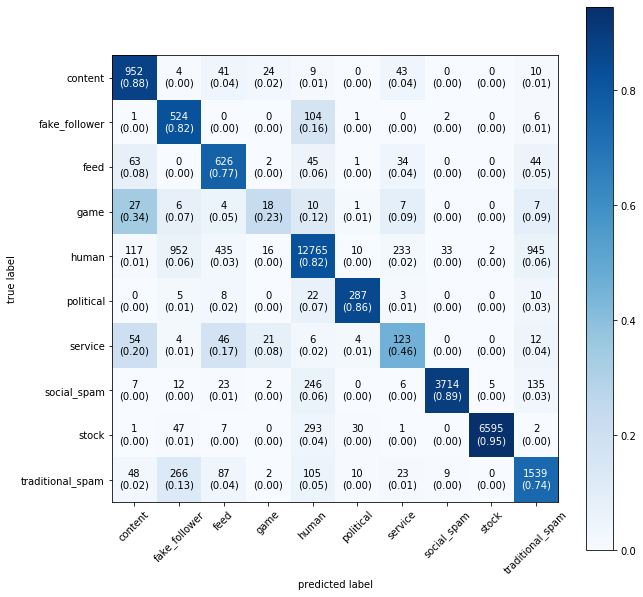

In [28]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import ADASYN

clf = BernoulliNB()

pipeline = Pipeline([
    ("adasyn", ADASYN(sampling_strategy={3:800}, n_neighbors=2, random_state=42, n_jobs=os.cpu_count())),
    ("feature_binning", ColumnTransformer(
        transformers=[
            ("binning", KBinsDiscretizer(encode="onehot", strategy="kmeans", n_bins=55), continous_features_idx)
        ],
        remainder="passthrough")),
    ("var_threshold", VarianceThreshold()),
    ("clf", clf)])

eval_scores = evaluate_model(pipeline, X, y, label_names)
print_eval(eval_scores, label_names, console_confm_print=False)

#### smote

In [ ]:
from imblearn.pipeline import Pipeline
from sklearn.naive_bayes import BernoulliNB
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE

clf = BernoulliNB()

pipeline = Pipeline([
    ("smote", SMOTE(random_state=42, n_jobs=os.cpu_count()))
    ("feature_binning", ColumnTransformer(
        transformers=[
            ("binning", KBinsDiscretizer(encode="onehot"), continous_features_idx)
        ],
        remainder="passthrough")),
    ("var_threshold", VarianceThreshold()),
    ("clf", clf)])

params = {
    "feature_binning__binning__n_bins": range(2,51,10),
    "feature_binning__binning__strategy": ["quantile", "kmeans", "uniform"],
    "smote__n_neighbors": range(1,61,10),
    "smote__sampling_strategy": [{3:250}, {3:500}, {3:800}]
}

gs = CustomGridSearchCV(pipeline, params=params)
scores = gs.fit(X, y, label_names)
best_params_idx = np.argmax(scores["f1_scores"])
pp.pprint(scores["f1_scores"][best_params_idx])
pp.pprint(scores["params"][best_params_idx])
# pp.pprint(scores["fold_scores"][best_params_idx])

best:
- bnb:
1. n bins: 57
2. strategy: quantile
- adasyn:
1. k neigbors: 1
2. sampling strategy: 3:800

F1 Score (macro): 0.667
ROC AUC (macro): 0.978
Human Bot AUC: 0.945
Bot type AUC (macro): 0.973
content
	F1 Score (mean): 0.807
	ROC AUC (mean): 0.993
fake_follower
	F1 Score (mean): 0.411
	ROC AUC (mean): 0.964
feed
	F1 Score (mean): 0.580
	ROC AUC (mean): 0.981
game
	F1 Score (mean): 0.281
	ROC AUC (mean): 0.968
human
	F1 Score (mean): 0.881
	ROC AUC (mean): 0.961
political
	F1 Score (mean): 0.837
	ROC AUC (mean): 0.994
service
	F1 Score (mean): 0.258
	ROC AUC (mean): 0.964
social_spam
	F1 Score (mean): 0.970
	ROC AUC (mean): 0.992
stock
	F1 Score (mean): 0.971
	ROC AUC (mean): 0.997
traditional_spam
	F1 Score (mean): 0.674
	ROC AUC (mean): 0.968


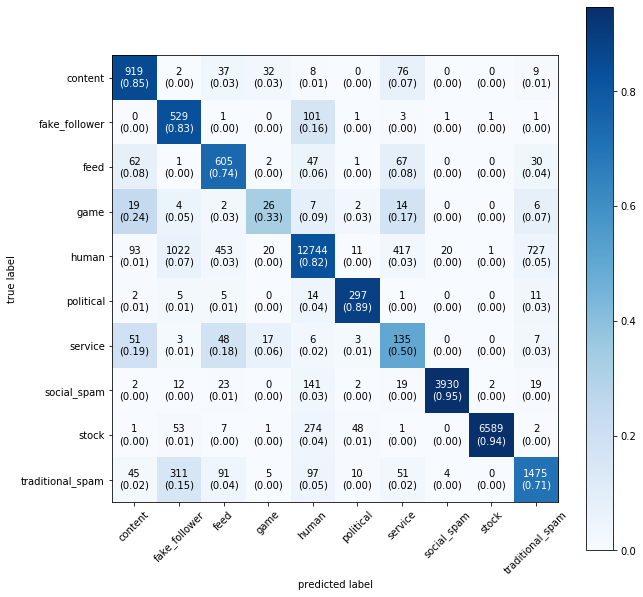

In [29]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

clf = BernoulliNB()

pipeline = Pipeline([
    ("smote", SMOTE(sampling_strategy={3:800}, k_neighbors=1, random_state=42, n_jobs=os.cpu_count())),
    ("feature_binning", ColumnTransformer(
        transformers=[
            ("binning", KBinsDiscretizer(encode="onehot", strategy="quantile", n_bins=57), continous_features_idx)
        ],
        remainder="passthrough")),
    ("var_threshold", VarianceThreshold()),
    ("clf", clf)])

eval_scores = evaluate_model(pipeline, X, y, label_names)
print_eval(eval_scores, label_names, console_confm_print=False)

### different train size

In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import BernoulliNB
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.feature_selection import VarianceThreshold

clf = BernoulliNB()

pipeline = Pipeline([
    ("feature_binning", ColumnTransformer(
        transformers=[
            ("binning", KBinsDiscretizer(encode="onehot", strategy="quantile", n_bins=35), continous_features_idx)
        ],
        remainder="passthrough")),
    ("var_threshold", VarianceThreshold()),
    ("clf", clf)])

plot_diff_train_size_f1(pipeline, X, y, "BNB")

NameError: name 'ColumnTransformer' is not defined

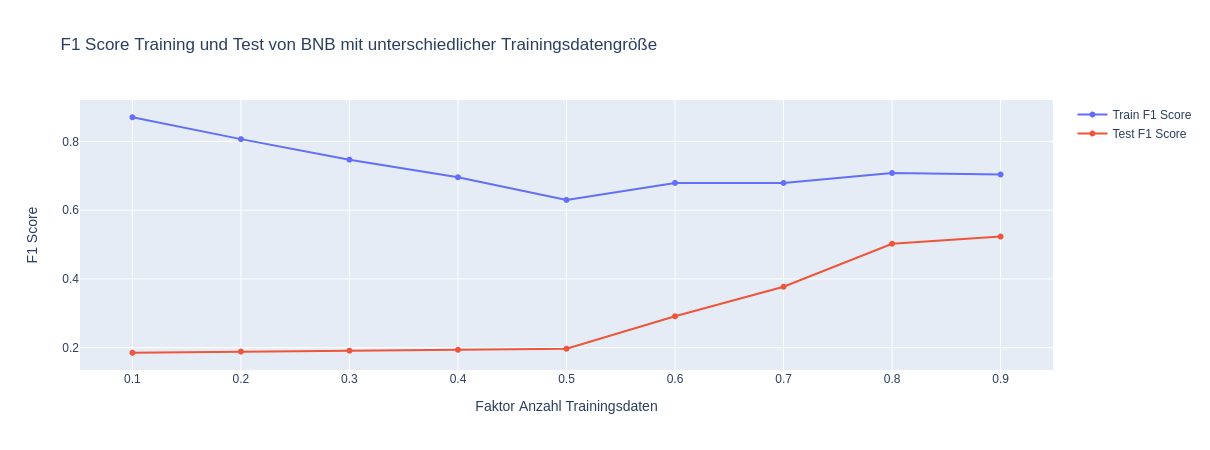

In [32]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import BernoulliNB
from sklearn.feature_selection import VarianceThreshold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import learning_curve, StratifiedKFold

import plotly.graph_objects as go

percentiles = [
    99.9,
    95,
    90,
    85,
    80,
    75,
    70,
    65,
    60,
    55,
    50,
    45,
    40,
    35,
    30,
    25,
    20,
    15,
    10,
    5,
    0.01
]

def custom_column_transformer(X):
    X_new = np.empty_like(X)
    for i in range(X.shape[1]):
        bins = [np.percentile(X[:,i], p) for p in percentiles]
        binned = np.digitize(X[:,i], bins, right=False)
        X_new[:,i] = binned

    return X_new


clf = BernoulliNB()

ct = ColumnTransformer(
        transformers=[
            ("binning", FunctionTransformer(func=custom_column_transformer), continous_features_idx),
        ],
        remainder="passthrough",
        n_jobs=os.cpu_count())

X_new = ct.fit_transform(X)
X_new = OneHotEncoder(sparse=False).fit_transform(X_new)
X_new = VarianceThreshold().fit_transform(X_new)

train_size_factors = np.linspace(0.1, 0.9, 9)

train_sizes, train_scores, test_scores = learning_curve(clf, 
                                                        X_new, 
                                                        y, 
                                                        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                                                        scoring="f1_macro",
                                                        n_jobs=os.cpu_count(), 
                                                        train_sizes=train_size_factors)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

fig = go.Figure(data=[
    go.Scatter(x=train_size_factors, y=train_scores_mean, name="Train F1 Score"),
    go.Scatter(x=train_size_factors, y=test_scores_mean, name="Test F1 Score"),
])
fig.update_layout(title="F1 Score Training und Test von BNB mit unterschiedlicher Trainingsdatengröße",
                   xaxis_title="Faktor Anzahl Trainingsdaten",
                   yaxis_title="F1 Score")
fig.show()

## Random Forest

Best model:
- smote
- F1 Score: 0.867
- ROC AUC: 0.993
- Bot AUC: 0.979
- Bot type AUC: 0.976

#### Basic

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

clf = RandomForestClassifier(random_state=42, n_jobs=os.cpu_count())
pipeline = Pipeline([("clf", clf)])

param_grid = {
    "clf__max_depth": range(20, 30, 1),
    "clf__criterion": ["entropy"],
    "clf__max_features": range(145, 155, 1)
}

gs = CustomGridSearchCV(pipeline, estimator_params=param_grid)
scores = gs.fit(X, y, label_names)
best_params_idx = np.argmax(scores["f1_scores"])
pp.pprint(scores["f1_scores"][best_params_idx])
pp.pprint(scores["params"][best_params_idx])
pp.pprint(scores["fold_scores"][best_params_idx])

Number of fits: 100
100/100 (avg 599.05s/job)0.8511888056980835
(   {   'clf__criterion': 'entropy',
        'clf__max_depth': 21,
        'clf__max_features': 150},
    {})
{   'bot_aucs': [   0.9794960087650649,
                    0.9794960087650649,
                    0.9809046799186101,
                    0.9782438566285804,
                    0.9769881026925485],
    'bot_type_aucs': [   0.9754265143214901,
                         0.9763656284238535,
                         0.9782438566285804,
                         0.9751134762873689,
                         0.9749530369442705],
    'class_scores': {   'content': {   'f1_scores': [   0.8903803131991052,
                                                        0.8758169934640523,
                                                        0.912751677852349,
                                                        0.9070796460176992,
                                                        0.8995633187772927],
                   

Process GridSearchWatch-8:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "<ipython-input-16-6dd8e7722eee>", line 52, in run
    worker_time = self.worker_times_q.get()
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 94, in get
    res = self._recv_bytes()
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt


- entropy
- depth=21
- features=150

F1 Score (macro): 0.851
ROC AUC (macro): 0.992
Human Bot AUC: 0.997
Bot type AUC (macro): 0.997
content
	F1 Score (mean): 0.897
	ROC AUC (mean): 0.996
fake_follower
	F1 Score (mean): 0.862
	ROC AUC (mean): 0.987
feed
	F1 Score (mean): 0.864
	ROC AUC (mean): 0.994
game
	F1 Score (mean): 0.336
	ROC AUC (mean): 0.967
human
	F1 Score (mean): 0.979
	ROC AUC (mean): 0.997
political
	F1 Score (mean): 0.979
	ROC AUC (mean): 0.998
service
	F1 Score (mean): 0.688
	ROC AUC (mean): 0.991
social_spam
	F1 Score (mean): 0.988
	ROC AUC (mean): 0.998
stock
	F1 Score (mean): 0.986
	ROC AUC (mean): 0.999
traditional_spam
	F1 Score (mean): 0.934
	ROC AUC (mean): 0.994


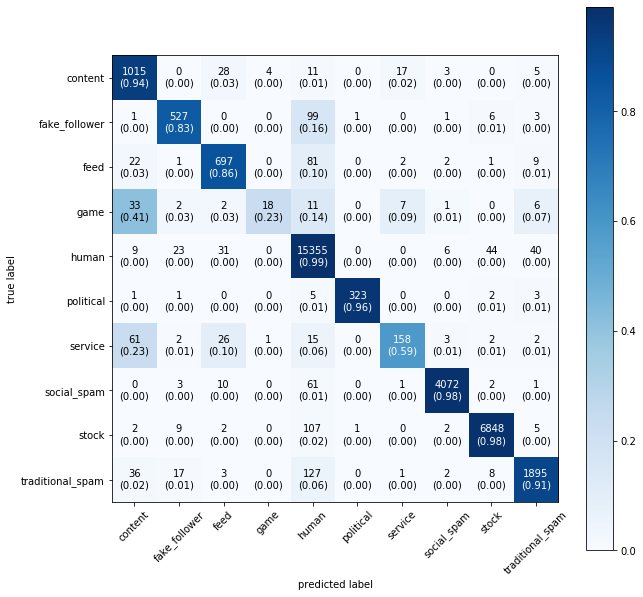

In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

clf = RandomForestClassifier(max_depth=21, max_features=150, criterion="entropy", random_state=42, n_jobs=os.cpu_count())
pipeline = Pipeline([("clf", clf)])

eval_scores = evaluate_model(pipeline, X, y, label_names)
print_eval(eval_scores, label_names, console_confm_print=False)

### oversampling game class

#### adasyn

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import ADASYN

clf = RandomForestClassifier(random_state=42, n_jobs=os.cpu_count())

pipeline = Pipeline([
    ("adasyn", ADASYN(random_state=42, n_jobs=os.cpu_count())),
    ("clf", clf)])

params = {
    "clf__max_depth": range(1, 150, 30),
    "clf__criterion": ["entropy", "gini"],
    "clf__max_features": range(1, X.shape[1] + 1, 50),
    "adasyn__n_neighbors": range(1,51,10),
    "adasyn__sampling_strategy": [{3:500}, {3:800}]
}

gs = CustomGridSearchCV(pipeline, params=params)
scores = gs.fit(X, y, label_names)
best_params_idx = np.argmax(scores["f1_scores"])
pp.pprint(scores["f1_scores"][best_params_idx])
pp.pprint(scores["params"][best_params_idx])
# pp.pprint(scores["fold_scores"][best_params_idx])

rf:
- clf__criterion: entropy
- clf__max_depth: 20
- clf__max_features: 156

adasyn:
- k_neighbors: 20
- sampling_strategy: 3: 250

F1 Score (macro): 0.867
ROC AUC (macro): 0.993
Human Bot AUC: 0.997
Bot type AUC (macro): 0.998
content
	F1 Score (mean): 0.896
	ROC AUC (mean): 0.996
fake_follower
	F1 Score (mean): 0.870
	ROC AUC (mean): 0.988
feed
	F1 Score (mean): 0.862
	ROC AUC (mean): 0.996
game
	F1 Score (mean): 0.487
	ROC AUC (mean): 0.971
human
	F1 Score (mean): 0.979
	ROC AUC (mean): 0.997
political
	F1 Score (mean): 0.980
	ROC AUC (mean): 0.998
service
	F1 Score (mean): 0.689
	ROC AUC (mean): 0.994
social_spam
	F1 Score (mean): 0.989
	ROC AUC (mean): 0.998
stock
	F1 Score (mean): 0.987
	ROC AUC (mean): 0.999
traditional_spam
	F1 Score (mean): 0.934
	ROC AUC (mean): 0.995


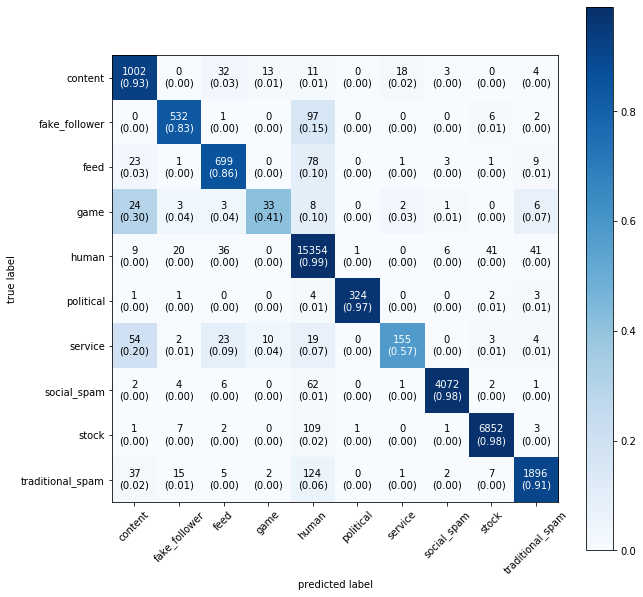

In [31]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import ADASYN
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=20, max_features=156, criterion="entropy", random_state=42, n_jobs=os.cpu_count())

adasyn = ADASYN(sampling_strategy={3:250}, n_neighbors=20, random_state=42, n_jobs=os.cpu_count())

pipeline = Pipeline([("adasyn", adasyn), ("clf", clf)])

eval_scores = evaluate_model(pipeline, X, y, label_names)
print_eval(eval_scores, label_names, console_confm_print=False)

#### smote

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

clf = RandomForestClassifier(random_state=42, n_jobs=os.cpu_count())

pipeline = Pipeline([
    ("smote", SMOTE(random_state=42, n_jobs=os.cpu_count())),
    ("clf", clf)])

params = {
    "clf__max_depth": range(1, 150, 30),
    "clf__criterion": ["entropy", "gini"],
    "clf__max_features": range(1, X.shape[1] + 1, 50),
    "smote__k_neighbors": range(1,51,1),
    "smote__sampling_strategy": [{3:500}, {3:800}]
}

gs = CustomGridSearchCV(pipeline, params=params)
scores = gs.fit(X, y, label_names)
best_params_idx = np.argmax(scores["f1_scores"])
pp.pprint(scores["f1_scores"][best_params_idx])
pp.pprint(scores["params"][best_params_idx])
# pp.pprint(scores["fold_scores"][best_params_idx])

rf:
- clf__criterion: entropy
- clf__max_depth: 19,
- clf__max_features: 134

smote:
- k_neighbors: 27
- sampling_strategy: 3: 500

F1 Score (macro): 0.867
ROC AUC (macro): 0.993
Human Bot AUC: 0.997
Bot type AUC (macro): 0.998
content
	F1 Score (mean): 0.895
	ROC AUC (mean): 0.996
fake_follower
	F1 Score (mean): 0.859
	ROC AUC (mean): 0.988
feed
	F1 Score (mean): 0.862
	ROC AUC (mean): 0.997
game
	F1 Score (mean): 0.523
	ROC AUC (mean): 0.965
human
	F1 Score (mean): 0.978
	ROC AUC (mean): 0.997
political
	F1 Score (mean): 0.976
	ROC AUC (mean): 0.998
service
	F1 Score (mean): 0.664
	ROC AUC (mean): 0.992
social_spam
	F1 Score (mean): 0.988
	ROC AUC (mean): 0.998
stock
	F1 Score (mean): 0.986
	ROC AUC (mean): 0.999
traditional_spam
	F1 Score (mean): 0.935
	ROC AUC (mean): 0.994


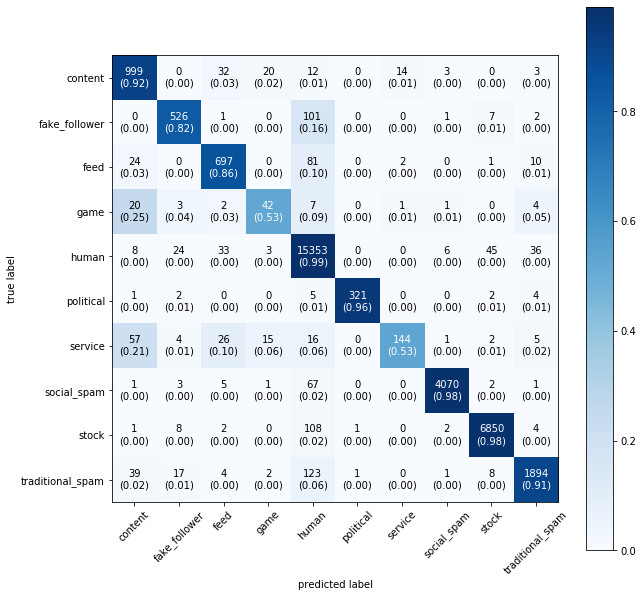

In [32]:
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=19, max_features=134, criterion="entropy", random_state=42, n_jobs=os.cpu_count())

smote = SMOTE(sampling_strategy={3:500}, k_neighbors=27, random_state=42, n_jobs=os.cpu_count())

pipeline = Pipeline([("smote", smote), ("clf", clf)])

eval_scores = evaluate_model(pipeline, X, y, label_names)
print_eval(eval_scores, label_names, console_confm_print=False)

### Feature importance

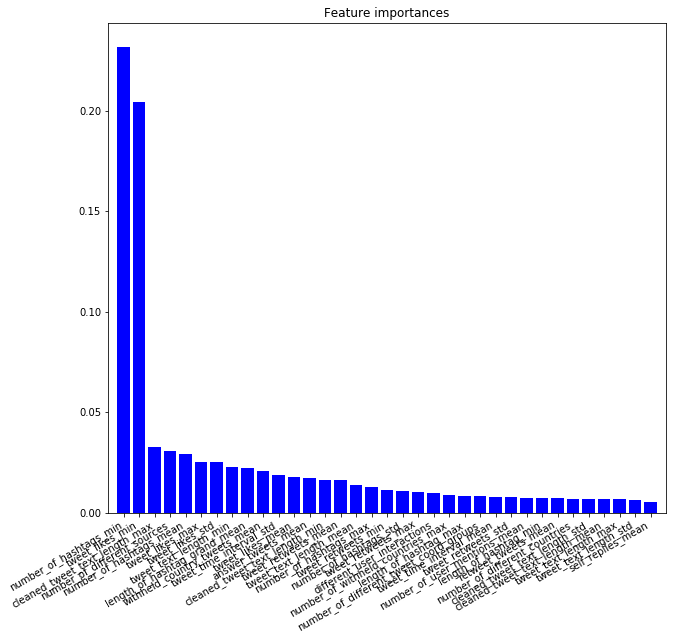

In [16]:
import matplotlib.pyplot as plt
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=19, max_features=134, criterion="entropy", random_state=42, n_jobs=os.cpu_count())

smote = SMOTE(sampling_strategy={3:500}, k_neighbors=27, random_state=42, n_jobs=os.cpu_count())

pipeline = Pipeline([("smote", smote), ("clf", clf)])

pipeline.fit(X, y)
importances = clf.feature_importances_
importances = importances[np.argwhere(importances > 0.005)].reshape(1,-1)[0]
indices = np.argsort(importances)[::-1]

f_names = np.asarray(user_features_index)

fig = plt.figure(figsize=(10,10))

plt.title("Feature importances")
plt.bar(f_names[indices], importances[indices],
       color="b", align="center")
plt.xlim([-1, importances.shape[0]])
fig.autofmt_xdate()
plt.show()

### different train sizes

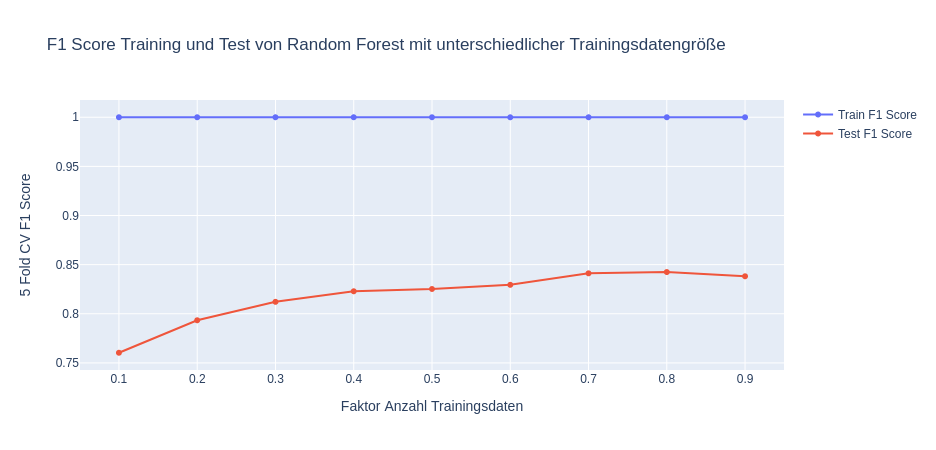

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

clf = RandomForestClassifier(max_depth=21, criterion="entropy", max_features=150, random_state=42, n_jobs=os.cpu_count())

pipeline = Pipeline([("clf", clf)])

plot_diff_train_size_f1(pipeline, X, y, "Random Forest")

## Decision Tree

Best model:
- basic
- F1 Score: 0.791
- ROC AUC: 0.901
- Bot AUC: 0.965
- Bot type AUC: 0.959

### Basic

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline

clf = DecisionTreeClassifier()
pipeline = Pipeline([("clf", clf)])

estimator_params = {
    "clf__max_depth": range(13,14, 1),
    "clf__criterion": ["entropy"],
    "clf__max_features": range(233,235,1)
}

gs = CustomGridSearchCV(pipeline, estimator_params=estimator_params)
scores = gs.fit(X, y, label_names)
best_params_idx = np.argmax(scores["f1_scores"])
pp.pprint(scores["f1_scores"][best_params_idx])
pp.pprint(scores["params"][best_params_idx])
pp.pprint(scores["fold_scores"][best_params_idx])

- max_depth: 13
- max_features: 234
- entropy

F1 Score (macro): 0.791
ROC AUC (macro): 0.901
Human Bot AUC: 0.965
Bot type AUC (macro): 0.959
content
	F1 Score (mean): 0.849
	ROC AUC (mean): 0.933
fake_follower
	F1 Score (mean): 0.756
	ROC AUC (mean): 0.879
feed
	F1 Score (mean): 0.765
	ROC AUC (mean): 0.888
game
	F1 Score (mean): 0.289
	ROC AUC (mean): 0.669
human
	F1 Score (mean): 0.964
	ROC AUC (mean): 0.965
political
	F1 Score (mean): 0.903
	ROC AUC (mean): 0.946
service
	F1 Score (mean): 0.547
	ROC AUC (mean): 0.819
social_spam
	F1 Score (mean): 0.975
	ROC AUC (mean): 0.986
stock
	F1 Score (mean): 0.975
	ROC AUC (mean): 0.984
traditional_spam
	F1 Score (mean): 0.886
	ROC AUC (mean): 0.939


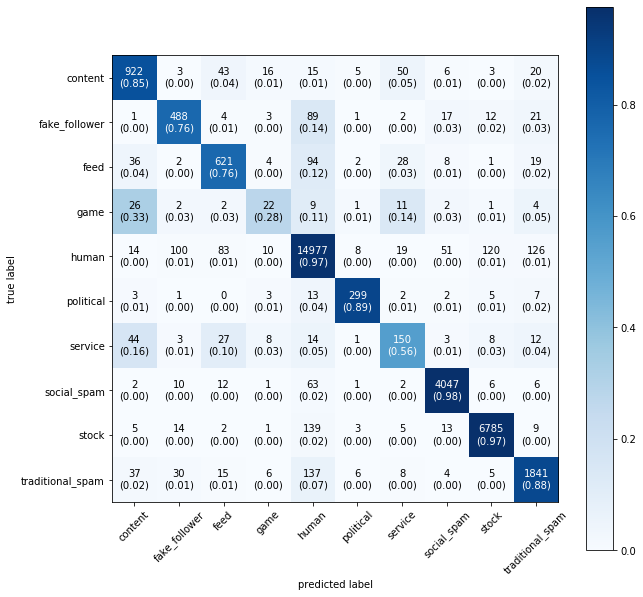

In [33]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline

clf = DecisionTreeClassifier(max_depth=13, criterion="entropy", max_features=234, random_state=42)
pipeline = Pipeline([("clf", clf)])

eval_scores = evaluate_model(pipeline, X, y, label_names)
print_eval(eval_scores, label_names, console_confm_print=False)

### oversampling game class

#### adasyn

In [ ]:
from imblearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import ADASYN

clf = DecisionTreeClassifier()

pipeline = Pipeline([
    ("adasyn", ADASYN(random_state=42, n_jobs=os.cpu_count())),
    ("clf", clf)])

params = {
    "clf__max_depth": range(1, 150, 30),
    "clf__criterion": ["entropy", "gini"],
    "clf__max_features": range(1, X.shape[1] + 1, 30),
    "adasyn__n_neighbors": range(1,61,20),
    "adasyn__sampling_strategy": [{3:250}, {3:500}, {3:800}]
}

gs = CustomGridSearchCV(pipeline, params=params)
scores = gs.fit(X, y, label_names)
best_params_idx = np.argmax(scores["f1_scores"])
pp.pprint(scores["f1_scores"][best_params_idx])
pp.pprint(scores["params"][best_params_idx])
# pp.pprint(scores["fold_scores"][best_params_idx])

DT:
- criterion: entropy
- clf__max_depth: 13
- clf__max_features: 220

ADASYN:
- adasyn__n_neighbors: 11,
- adasyn__sampling_strategy: 3: 500

F1 Score (macro): 0.777
ROC AUC (macro): 0.897
Human Bot AUC: 0.965
Bot type AUC (macro): 0.959
content
	F1 Score (mean): 0.836
	ROC AUC (mean): 0.923
fake_follower
	F1 Score (mean): 0.749
	ROC AUC (mean): 0.872
feed
	F1 Score (mean): 0.756
	ROC AUC (mean): 0.881
game
	F1 Score (mean): 0.247
	ROC AUC (mean): 0.697
human
	F1 Score (mean): 0.965
	ROC AUC (mean): 0.965
political
	F1 Score (mean): 0.903
	ROC AUC (mean): 0.955
service
	F1 Score (mean): 0.485
	ROC AUC (mean): 0.772
social_spam
	F1 Score (mean): 0.978
	ROC AUC (mean): 0.987
stock
	F1 Score (mean): 0.974
	ROC AUC (mean): 0.982
traditional_spam
	F1 Score (mean): 0.881
	ROC AUC (mean): 0.937


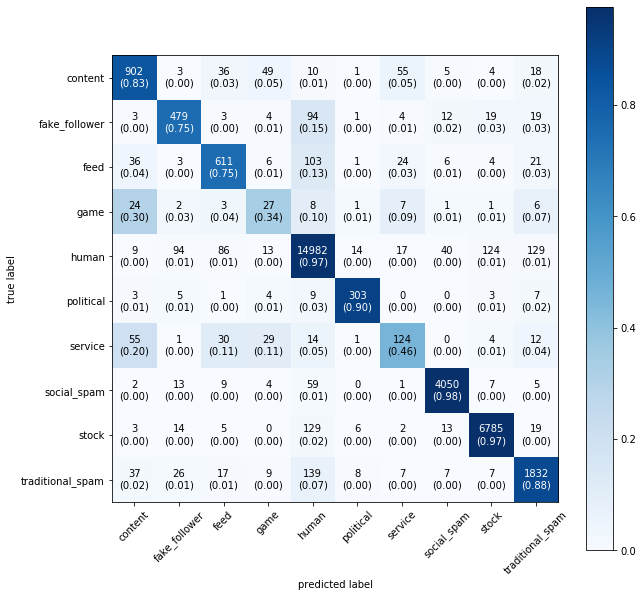

In [34]:
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import ADASYN

clf = DecisionTreeClassifier(max_depth=13, criterion="entropy", max_features=220)

pipeline = Pipeline([
    ("adasyn", ADASYN(sampling_strategy={3:500}, n_neighbors=11, random_state=42, n_jobs=os.cpu_count())),
    ("clf", clf)])

eval_scores = evaluate_model(pipeline, X, y, label_names)
print_eval(eval_scores, label_names, console_confm_print=False)

#### smote

In [16]:
from imblearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE

clf = DecisionTreeClassifier()

pipeline = Pipeline([
    ("smote", SMOTE(random_state=42, n_jobs=os.cpu_count())),
    ("clf", clf)])

params = {
    "clf__max_depth": range(119, 120, 1),
    "clf__criterion": ["entropy"],
    "clf__max_features": range(225,X.shape[1]+1, 1),
    "smote__k_neighbors": range(1,3,1),
    "smote__sampling_strategy": [{3:250}, {3:500}, {3:800}]
}

gs = CustomGridSearchCV(pipeline, params=params)
scores = gs.fit(X, y, label_names)
best_params_idx = np.argmax(scores["f1_scores"])
pp.pprint(scores["f1_scores"][best_params_idx])
pp.pprint(scores["params"][best_params_idx])
# pp.pprint(scores["fold_scores"][best_params_idx])

Number of fits: 60
60/60 (avg 19.05s/job, total: 3.2min, ETA: 0.0min)0.7903272779775707
{   'clf__criterion': 'entropy',
    'clf__max_depth': 119,
    'clf__max_features': 228,
    'smote__k_neighbors': 1,
    'smote__sampling_strategy': {3: 250}}


F1 Score (macro): 0.782
ROC AUC (macro): 0.891
Human Bot AUC: 0.964
Bot type AUC (macro): 0.958
content
	F1 Score (mean): 0.837
	ROC AUC (mean): 0.913
fake_follower
	F1 Score (mean): 0.765
	ROC AUC (mean): 0.883
feed
	F1 Score (mean): 0.747
	ROC AUC (mean): 0.869
game
	F1 Score (mean): 0.269
	ROC AUC (mean): 0.673
human
	F1 Score (mean): 0.963
	ROC AUC (mean): 0.964
political
	F1 Score (mean): 0.912
	ROC AUC (mean): 0.952
service
	F1 Score (mean): 0.494
	ROC AUC (mean): 0.746
social_spam
	F1 Score (mean): 0.976
	ROC AUC (mean): 0.987
stock
	F1 Score (mean): 0.975
	ROC AUC (mean): 0.983
traditional_spam
	F1 Score (mean): 0.883
	ROC AUC (mean): 0.936


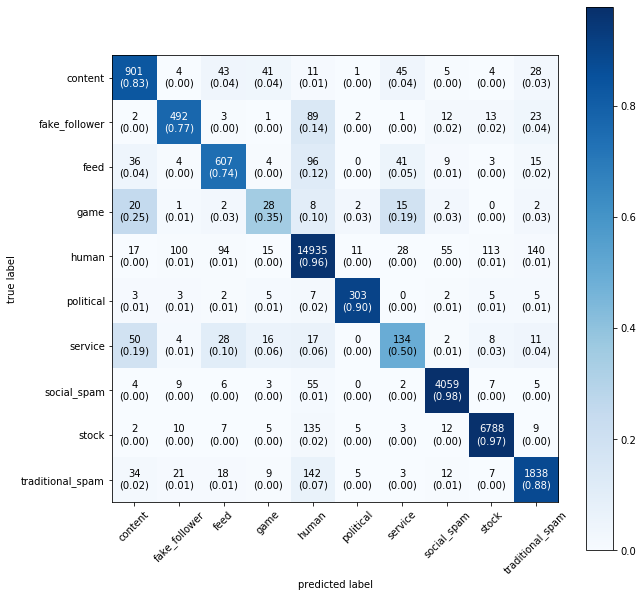

In [35]:
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

clf = DecisionTreeClassifier(max_depth=119, criterion="entropy", max_features=228)

pipeline = Pipeline([
    ("smote", SMOTE(sampling_strategy={3:250}, k_neighbors=1, random_state=42, n_jobs=os.cpu_count())),
    ("clf", clf)])

eval_scores = evaluate_model(pipeline, X, y, label_names)
print_eval(eval_scores, label_names, console_confm_print=False)

### Feature importance

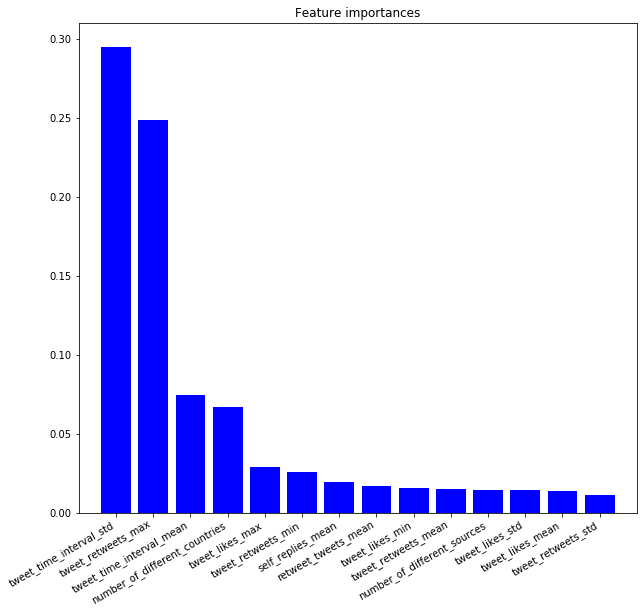

In [23]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline

clf = DecisionTreeClassifier(max_depth=13, criterion="entropy", max_features=234, random_state=42)

clf.fit(X, y)
importances = clf.feature_importances_
importances = importances[np.argwhere(importances > 0.01)].reshape(1,-1)[0]
indices = np.argsort(importances)[::-1]

f_names = np.asarray(user_features_index)

fig = plt.figure(figsize=(10,10))

plt.title("Feature importances")
plt.bar(f_names[indices], importances[indices],
       color="b", align="center")
plt.xlim([-1, importances.shape[0]])
fig.autofmt_xdate()
plt.show()

### different train sizes

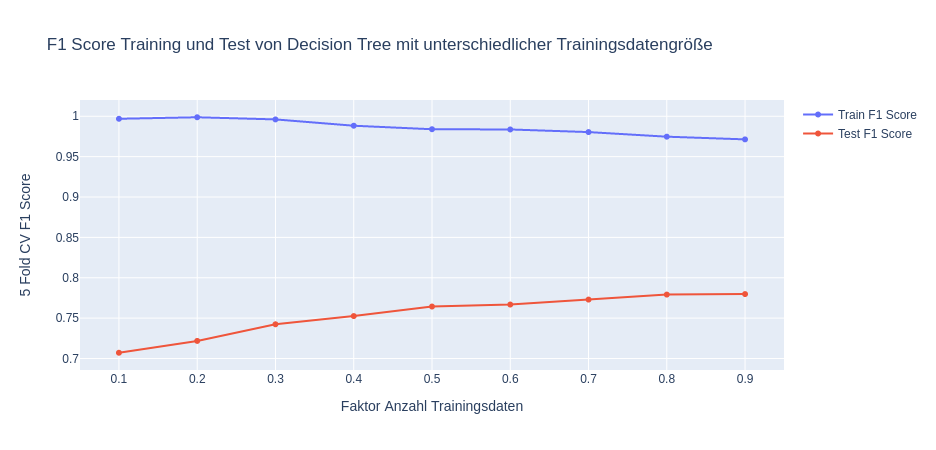

In [24]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

clf = DecisionTreeClassifier(max_depth=13, criterion="entropy", max_features=234, random_state=42)

pipeline = Pipeline([("clf", clf)])

plot_diff_train_size_f1(pipeline, X, y, "Decision Tree")

## Deep Neuronal Network

Best model:
- min max + basic
- F1 Score: 0.821
- ROC AUC: 0.984
- Bot AUC: 0.965
- Bot type AUC: 0.962
- LOG LOSS: 0.366

### Basic

scale values between 0 and 1

Restoring model weights from the end of the best epoch.
Epoch 00167: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00183: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00242: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00125: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00164: early stopping
F1 Score (macro): 0.824
ROC AUC (macro): 0.986
Human Bot AUC: 0.991
Bot type AUC (macro): 0.992
LOG LOSS (mean): 0.344
content
	F1 Score (mean): 0.874
	ROC AUC (mean): 0.996
fake_follower
	F1 Score (mean): 0.732
	ROC AUC (mean): 0.975
feed
	F1 Score (mean): 0.854
	ROC AUC (mean): 0.993
game
	F1 Score (mean): 0.389
	ROC AUC (mean): 0.950
human
	F1 Score (mean): 0.965
	ROC AUC (mean): 0.991
political
	F1 Score (mean): 0.957
	ROC AUC (mean): 0.999
service
	F1 Score (mean): 0.605
	ROC AUC (mean): 0.971
social_spam
	F1 Score (mean): 0.989
	ROC AUC (mean): 0.998
stock
	F1 Score (

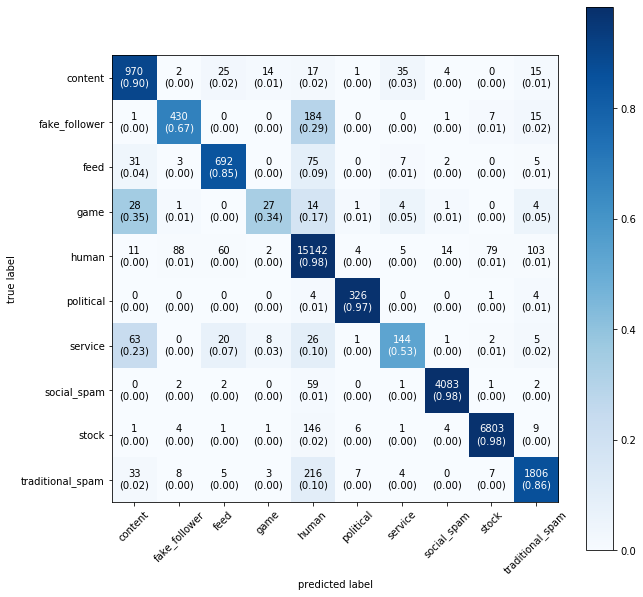

In [41]:
import tensorflow as tf
from sklearn.metrics import f1_score, roc_curve, accuracy_score, confusion_matrix, log_loss, auc, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler

X_min_max = MinMaxScaler().fit_transform(X)

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(X.shape[1],)),
    tf.keras.layers.Dense(X.shape[1], activation="relu"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(150, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(80, activation="relu"),
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

es = tf.keras.callbacks.EarlyStopping(monitor="sparse_categorical_accuracy", mode="max", patience=15, restore_best_weights=True, verbose=1)

scores = {"f1_scores": [], "roc_auc_macro": [], "confusion_matrices": [], "bot_aucs": [], "bot_type_aucs": [],
              "class_scores": {}, "fpr_macro": [], "tpr_macro": [], "log_loss": []}

for l in label_names:
    scores["class_scores"][l] = {
        "f1_scores": [],
        "roc_aucs": [],
        "fpr": [],
        "tpr": []
    }


for train_index, test_index in StratifiedKFold(n_splits=5, shuffle=True, random_state=42).split(X_min_max, y):
    f1_scores = []

    X_train, X_test = X_min_max[train_index], X_min_max[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    model = tf.keras.models.clone_model(model)
    
    model.compile(
      optimizer=tf.keras.optimizers.Adamax(learning_rate=0.002, beta_1=0.9, beta_2=0.999),
      loss="sparse_categorical_crossentropy",
      metrics=["sparse_categorical_accuracy"]
    )

    model.fit(X_train,
      y_train,
      epochs=800,
      batch_size=64,
      callbacks=[es],
      verbose=0)
    
    y_pred_prob = model.predict_proba(X_test)

    y_true = OneHotEncoder().fit_transform(y_test.reshape(-1, 1)).toarray()

    fpr = dict()
    tpr = dict()
    roc_aucs = dict()
    for i, l in enumerate(label_names):
        fpr[l], tpr[l], _ = roc_curve(y_true[:, i], y_pred_prob[:, i])
        roc_aucs[l] = auc(fpr[l], tpr[l])

    all_fpr = np.unique(np.concatenate([fpr[l] for l in label_names]))

    mean_tpr = np.zeros_like(all_fpr)
    for l in label_names:
        mean_tpr += np.interp(all_fpr, fpr[l], tpr[l])

    mean_tpr /= len(label_names)
        
    scores["fpr_macro"] = all_fpr
    scores["tpr_macro"] = mean_tpr

    y_pred = np.argmax(y_pred_prob, axis=1)

    f1_scores = f1_score(y_test, y_pred, average=None)
        
    mean_fpr = np.linspace(0, 1, 10)

    for i, l in enumerate(label_names):
        scores["class_scores"][l]["f1_scores"].append(f1_scores[i])
        scores["class_scores"][l]["roc_aucs"].append(roc_aucs[l])
            
        scores["class_scores"][l]["fpr"].append(fpr[l])
        scores["class_scores"][l]["tpr"].append(tpr[l])            

    scores["f1_scores"].append(np.mean(f1_scores))
    scores["roc_auc_macro"].append(auc(all_fpr, mean_tpr))
    scores["confusion_matrices"].append(confusion_matrix(y_test, y_pred))

    scores["log_loss"].append(log_loss(y_test, y_pred_prob, eps=1e-15))

    y_test_2 = np.copy(y_test)
    y_test_2[y_test_2 != label_names.index("human")] = -1
        
    # column 0: bot
    # column 1: human
    y_test_2_oh = OneHotEncoder().fit_transform(y_test_2.reshape(-1,1)).toarray()
        
    y_pred_prob_2 = np.zeros((y_pred_prob.shape[0], 2))
        
    y_pred_prob_2[:,1] = y_pred_prob[:,label_names.index("human")]
        
    y_pred_prob_2[:,0] = y_pred_prob[:, [i for i, n in enumerate(label_names) if n != "human"]].sum(axis=1)
        
    scores["bot_aucs"].append(roc_auc_score(y_test_2_oh, y_pred_prob_2))

    y_test_2 = np.copy(y_test)
    # good bots
    y_test_2[y_test_2 == label_names.index("content")] = -2
    y_test_2[y_test_2 == label_names.index("feed")] = -2
    y_test_2[y_test_2 == label_names.index("game")] = -2
    y_test_2[y_test_2 == label_names.index("service")] = -2
    # bad bots
    y_test_2[y_test_2 == label_names.index("fake_follower")] = -1
    y_test_2[y_test_2 == label_names.index("political")] = -1
    y_test_2[y_test_2 == label_names.index("social_spam")] = -1
    y_test_2[y_test_2 == label_names.index("stock")] = -1
    y_test_2[y_test_2 == label_names.index("traditional_spam")] = -1
        
    # column 0: good bot
    # column 1: bad bot
    # column 2: human
    y_test_2_oh = OneHotEncoder().fit_transform(y_test_2.reshape(-1,1)).toarray()

    y_pred_prob_2 = np.zeros((y_pred_prob.shape[0], 3))
    # good bots
    y_pred_prob_2[:,0] = y_pred_prob[:, [i for i, n in enumerate(label_names) if n in ["content", "feed", "game", "service"]]].sum(axis=1)
    # bad bots
    y_pred_prob_2[:,1] = y_pred_prob[:, [i for i, n in enumerate(label_names) if n in ["fake_follower", "political", "social_spam", "stock", "traditional_spam"]]].sum(axis=1)
        
    y_pred_prob_2[:,2] = y_pred_prob[:,label_names.index("human")]
                                                         
    scores["bot_type_aucs"].append(roc_auc_score(y_test_2_oh, y_pred_prob_2, average="macro", multi_class="ovr"))

print_eval(scores, label_names, console_confm_print=False)

### Oversampling game class

#### adasyn

In [ ]:
import tensorflow as tf
from sklearn.metrics import f1_score, roc_curve, accuracy_score, confusion_matrix, log_loss, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler

X_min_max = MinMaxScaler().fit_transform(X)

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(X.shape[1],)),
    tf.keras.layers.Dense(X.shape[1], activation="relu"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(150, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(80, activation="relu"),
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

es = tf.keras.callbacks.EarlyStopping(monitor="sparse_categorical_accuracy", mode="max", patience=15, restore_best_weights=True, verbose=1)

res = []

for i in range(1,17,2):

    for train_index, test_index in StratifiedKFold(n_splits=3, shuffle=True, random_state=42).split(X_min_max, y):
        f1_scores = []

        X_train, X_test = X_min_max[train_index], X_min_max[test_index]
        y_train, y_test = y[train_index], y[test_index]

        X_train, y_train = oversampling_adasyn(X_train, y_train, {"n_neighbors" : i, "sampling_strategy": {3:800}})

        model = tf.keras.models.clone_model(model)

        model.compile(
            optimizer=tf.keras.optimizers.Adamax(learning_rate=0.002, beta_1=0.9, beta_2=0.999),
            loss="sparse_categorical_crossentropy",
            metrics=["sparse_categorical_accuracy"]
        )

        model.fit(
            X_train,
            y_train,
            epochs=800,
            batch_size=64,
            callbacks=[es],
            verbose=0
        )

        y_pred_prob = model.predict_proba(X_test)
        
        y_pred = np.argmax(y_pred_prob, axis=1)

        f1_scores = f1_score(y_test, y_pred, average=None)

        res.append((i, f1_scores))

r = {}
for i in res:
    if i[0] in r:
        r[i[0]].append(np.mean(i[1]))
    else:
        r[i[0]] = [np.mean(i[1])]
    
for i, f in r.items():
    print(i, np.mean(f))

best:
 - k_neighbors: 9
 - sampling_strategy: 800

Restoring model weights from the end of the best epoch.
Epoch 00151: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00192: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00162: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00203: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00222: early stopping
F1 Score (macro): 0.818
ROC AUC (macro): 0.981
Human Bot AUC: 0.990
Bot type AUC (macro): 0.992
LOG LOSS (mean): 0.373
content
	F1 Score (mean): 0.875
	ROC AUC (mean): 0.995
fake_follower
	F1 Score (mean): 0.711
	ROC AUC (mean): 0.972
feed
	F1 Score (mean): 0.851
	ROC AUC (mean): 0.994
game
	F1 Score (mean): 0.361
	ROC AUC (mean): 0.910
human
	F1 Score (mean): 0.964
	ROC AUC (mean): 0.990
political
	F1 Score (mean): 0.958
	ROC AUC (mean): 0.997
service
	F1 Score (mean): 0.607
	ROC AUC (mean): 0.973
social_spam
	F1 Score (mean): 0.988
	ROC AUC (mean): 0.998
stock
	F1 Score (

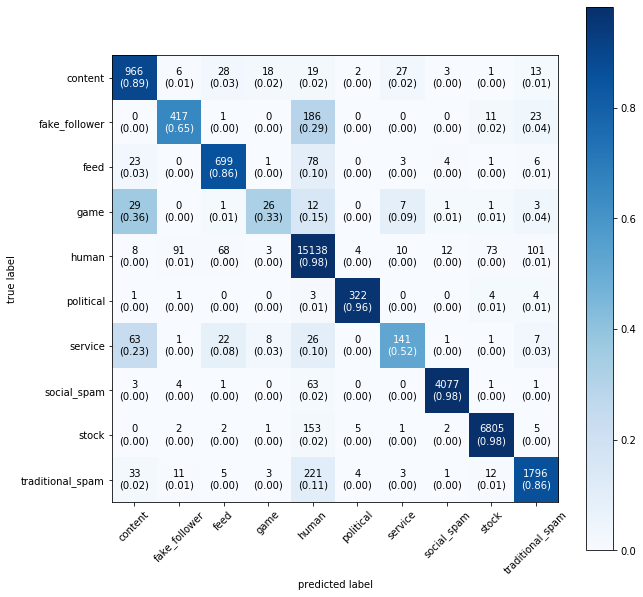

In [40]:
import tensorflow as tf
from sklearn.metrics import f1_score, roc_curve, accuracy_score, confusion_matrix, log_loss, auc, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler

X_min_max = MinMaxScaler().fit_transform(X)

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(X.shape[1],)),
    tf.keras.layers.Dense(X.shape[1], activation="relu"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(150, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(80, activation="relu"),
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

es = tf.keras.callbacks.EarlyStopping(monitor="sparse_categorical_accuracy", mode="max", patience=15, restore_best_weights=True, verbose=1)

scores = {"f1_scores": [], "roc_auc_macro": [], "confusion_matrices": [], "bot_aucs": [], "bot_type_aucs": [],
              "class_scores": {}, "fpr_macro": [], "tpr_macro": [], "log_loss": []}

for l in label_names:
    scores["class_scores"][l] = {
        "f1_scores": [],
        "roc_aucs": [],
        "fpr": [],
        "tpr": []
    }


for train_index, test_index in StratifiedKFold(n_splits=5, shuffle=True, random_state=42).split(X_min_max, y):
    f1_scores = []

    X_train, X_test = X_min_max[train_index], X_min_max[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    X_train, y_train = oversampling_adasyn(X_train, y_train, {"n_neighbors": 9, "sampling_strategy": {3:800}})
    
    model = tf.keras.models.clone_model(model)
    
    model.compile(
      optimizer=tf.keras.optimizers.Adamax(learning_rate=0.002, beta_1=0.9, beta_2=0.999),
      loss="sparse_categorical_crossentropy",
      metrics=["sparse_categorical_accuracy"]
    )

    model.fit(X_train,
      y_train,
      epochs=800,
      batch_size=64,
      callbacks=[es],
      verbose=0)
    
    y_pred_prob = model.predict_proba(X_test)

    y_true = OneHotEncoder().fit_transform(y_test.reshape(-1, 1)).toarray()

    fpr = dict()
    tpr = dict()
    roc_aucs = dict()
    for i, l in enumerate(label_names):
        fpr[l], tpr[l], _ = roc_curve(y_true[:, i], y_pred_prob[:, i])
        roc_aucs[l] = auc(fpr[l], tpr[l])

    all_fpr = np.unique(np.concatenate([fpr[l] for l in label_names]))

    mean_tpr = np.zeros_like(all_fpr)
    for l in label_names:
        mean_tpr += np.interp(all_fpr, fpr[l], tpr[l])

    mean_tpr /= len(label_names)
        
    scores["fpr_macro"] = all_fpr
    scores["tpr_macro"] = mean_tpr

    y_pred = np.argmax(y_pred_prob, axis=1)

    f1_scores = f1_score(y_test, y_pred, average=None)
        
    mean_fpr = np.linspace(0, 1, 10)

    for i, l in enumerate(label_names):
        scores["class_scores"][l]["f1_scores"].append(f1_scores[i])
        scores["class_scores"][l]["roc_aucs"].append(roc_aucs[l])
            
        scores["class_scores"][l]["fpr"].append(fpr[l])
        scores["class_scores"][l]["tpr"].append(tpr[l])            

    scores["f1_scores"].append(np.mean(f1_scores))
    scores["roc_auc_macro"].append(auc(all_fpr, mean_tpr))
    scores["confusion_matrices"].append(confusion_matrix(y_test, y_pred))

    scores["log_loss"].append(log_loss(y_test, y_pred_prob, eps=1e-15))

    y_test_2 = np.copy(y_test)
    y_test_2[y_test_2 != label_names.index("human")] = -1
        
    # column 0: bot
    # column 1: human
    y_test_2_oh = OneHotEncoder().fit_transform(y_test_2.reshape(-1,1)).toarray()
        
    y_pred_prob_2 = np.zeros((y_pred_prob.shape[0], 2))
        
    y_pred_prob_2[:,1] = y_pred_prob[:,label_names.index("human")]
        
    y_pred_prob_2[:,0] = y_pred_prob[:, [i for i, n in enumerate(label_names) if n != "human"]].sum(axis=1)
        
    scores["bot_aucs"].append(roc_auc_score(y_test_2_oh, y_pred_prob_2))

    y_test_2 = np.copy(y_test)
    # good bots
    y_test_2[y_test_2 == label_names.index("content")] = -2
    y_test_2[y_test_2 == label_names.index("feed")] = -2
    y_test_2[y_test_2 == label_names.index("game")] = -2
    y_test_2[y_test_2 == label_names.index("service")] = -2
    # bad bots
    y_test_2[y_test_2 == label_names.index("fake_follower")] = -1
    y_test_2[y_test_2 == label_names.index("political")] = -1
    y_test_2[y_test_2 == label_names.index("social_spam")] = -1
    y_test_2[y_test_2 == label_names.index("stock")] = -1
    y_test_2[y_test_2 == label_names.index("traditional_spam")] = -1
        
    # column 0: good bot
    # column 1: bad bot
    # column 2: human
    y_test_2_oh = OneHotEncoder().fit_transform(y_test_2.reshape(-1,1)).toarray()

    y_pred_prob_2 = np.zeros((y_pred_prob.shape[0], 3))
    # good bots
    y_pred_prob_2[:,0] = y_pred_prob[:, [i for i, n in enumerate(label_names) if n in ["content", "feed", "game", "service"]]].sum(axis=1)
    # bad bots
    y_pred_prob_2[:,1] = y_pred_prob[:, [i for i, n in enumerate(label_names) if n in ["fake_follower", "political", "social_spam", "stock", "traditional_spam"]]].sum(axis=1)
        
    y_pred_prob_2[:,2] = y_pred_prob[:,label_names.index("human")]
                                                         
    scores["bot_type_aucs"].append(roc_auc_score(y_test_2_oh, y_pred_prob_2, average="macro", multi_class="ovr"))

print_eval(scores, label_names, console_confm_print=False)

#### smote

In [ ]:
import tensorflow as tf
from sklearn.metrics import f1_score, roc_curve, accuracy_score, confusion_matrix, log_loss, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sampling.sampling import oversampling_smote

X_min_max = MinMaxScaler().fit_transform(X)

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(X.shape[1],)),
    tf.keras.layers.Dense(X.shape[1], activation="relu"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(150, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(80, activation="relu"),
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

es = tf.keras.callbacks.EarlyStopping(monitor="sparse_categorical_accuracy", mode="max", patience=15, restore_best_weights=True, verbose=1)

res = []

for i in range(1,17,2):

    for train_index, test_index in StratifiedKFold(n_splits=3, shuffle=True, random_state=42).split(X_min_max, y):
        f1_scores = []

        X_train, X_test = X_min_max[train_index], X_min_max[test_index]
        y_train, y_test = y[train_index], y[test_index]

        X_train, y_train = oversampling_smote(X_train, y_train, {"k_neighbors" : i, "sampling_strategy": {3:800}})

        model = tf.keras.models.clone_model(model)

        model.compile(
            optimizer=tf.keras.optimizers.Adamax(learning_rate=0.002, beta_1=0.9, beta_2=0.999),
            loss="sparse_categorical_crossentropy",
            metrics=["sparse_categorical_accuracy"]
        )

        model.fit(
            X_train,
            y_train,
            epochs=800,
            batch_size=64,
            callbacks=[es],
            verbose=0
        )

        y_pred_prob = model.predict_proba(X_test)
        
        y_pred = np.argmax(y_pred_prob, axis=1)

        f1_scores = f1_score(y_test, y_pred, average=None)

        res.append((i, f1_scores))

r = {}
for i in res:
    if i[0] in r:
        r[i[0]].append(np.mean(i[1]))
    else:
        r[i[0]] = [np.mean(i[1])]
    
for i, f in r.items():
    print(i, np.mean(f))

best:
 - k_neighbors: 18
 - sampling_strategy: 800

Restoring model weights from the end of the best epoch.
Epoch 00173: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00201: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00205: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00212: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00156: early stopping
F1 Score (macro): 0.828
ROC AUC (macro): 0.982
Human Bot AUC: 0.990
Bot type AUC (macro): 0.992
LOG LOSS (mean): 0.363
content
	F1 Score (mean): 0.876
	ROC AUC (mean): 0.995
fake_follower
	F1 Score (mean): 0.717
	ROC AUC (mean): 0.971
feed
	F1 Score (mean): 0.869
	ROC AUC (mean): 0.992
game
	F1 Score (mean): 0.388
	ROC AUC (mean): 0.925
human
	F1 Score (mean): 0.965
	ROC AUC (mean): 0.990
political
	F1 Score (mean): 0.967
	ROC AUC (mean): 0.998
service
	F1 Score (mean): 0.644
	ROC AUC (mean): 0.967
social_spam
	F1 Score (mean): 0.988
	ROC AUC (mean): 0.998
stock
	F1 Score (

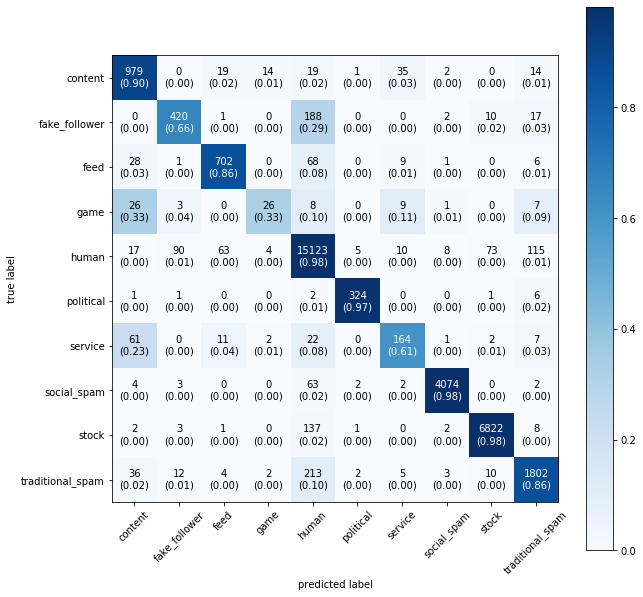

In [39]:
import tensorflow as tf
from sklearn.metrics import f1_score, roc_curve, accuracy_score, confusion_matrix, log_loss, auc, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler

X_min_max = MinMaxScaler().fit_transform(X)

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(X.shape[1],)),
    tf.keras.layers.Dense(X.shape[1], activation="relu"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(150, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(80, activation="relu"),
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

es = tf.keras.callbacks.EarlyStopping(monitor="sparse_categorical_accuracy", mode="max", patience=15, restore_best_weights=True, verbose=1)

scores = {"f1_scores": [], "roc_auc_macro": [], "confusion_matrices": [], "bot_aucs": [], "bot_type_aucs": [],
              "class_scores": {}, "fpr_macro": [], "tpr_macro": [], "log_loss": []}

for l in label_names:
    scores["class_scores"][l] = {
        "f1_scores": [],
        "roc_aucs": [],
        "fpr": [],
        "tpr": []
    }


for train_index, test_index in StratifiedKFold(n_splits=5, shuffle=True, random_state=42).split(X_min_max, y):
    f1_scores = []

    X_train, X_test = X_min_max[train_index], X_min_max[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    X_train, y_train = oversampling_smote(X_train, y_train, {"k_neighbors": 18, "sampling_strategy": {3:800}})
    
    model = tf.keras.models.clone_model(model)
    
    model.compile(
      optimizer=tf.keras.optimizers.Adamax(learning_rate=0.002, beta_1=0.9, beta_2=0.999),
      loss="sparse_categorical_crossentropy",
      metrics=["sparse_categorical_accuracy"]
    )

    model.fit(X_train,
      y_train,
      epochs=800,
      batch_size=64,
      callbacks=[es],
      verbose=0)
    
    y_pred_prob = model.predict_proba(X_test)

    y_true = OneHotEncoder().fit_transform(y_test.reshape(-1, 1)).toarray()

    fpr = dict()
    tpr = dict()
    roc_aucs = dict()
    for i, l in enumerate(label_names):
        fpr[l], tpr[l], _ = roc_curve(y_true[:, i], y_pred_prob[:, i])
        roc_aucs[l] = auc(fpr[l], tpr[l])

    all_fpr = np.unique(np.concatenate([fpr[l] for l in label_names]))

    mean_tpr = np.zeros_like(all_fpr)
    for l in label_names:
        mean_tpr += np.interp(all_fpr, fpr[l], tpr[l])

    mean_tpr /= len(label_names)
        
    scores["fpr_macro"] = all_fpr
    scores["tpr_macro"] = mean_tpr

    y_pred = np.argmax(y_pred_prob, axis=1)

    f1_scores = f1_score(y_test, y_pred, average=None)
        
    mean_fpr = np.linspace(0, 1, 10)

    for i, l in enumerate(label_names):
        scores["class_scores"][l]["f1_scores"].append(f1_scores[i])
        scores["class_scores"][l]["roc_aucs"].append(roc_aucs[l])
            
        scores["class_scores"][l]["fpr"].append(fpr[l])
        scores["class_scores"][l]["tpr"].append(tpr[l])            

    scores["f1_scores"].append(np.mean(f1_scores))
    scores["roc_auc_macro"].append(auc(all_fpr, mean_tpr))
    scores["confusion_matrices"].append(confusion_matrix(y_test, y_pred))

    scores["log_loss"].append(log_loss(y_test, y_pred_prob, eps=1e-15))

    y_test_2 = np.copy(y_test)
    y_test_2[y_test_2 != label_names.index("human")] = -1
        
    # column 0: bot
    # column 1: human
    y_test_2_oh = OneHotEncoder().fit_transform(y_test_2.reshape(-1,1)).toarray()
        
    y_pred_prob_2 = np.zeros((y_pred_prob.shape[0], 2))
        
    y_pred_prob_2[:,1] = y_pred_prob[:,label_names.index("human")]
        
    y_pred_prob_2[:,0] = y_pred_prob[:, [i for i, n in enumerate(label_names) if n != "human"]].sum(axis=1)
        
    scores["bot_aucs"].append(roc_auc_score(y_test_2_oh, y_pred_prob_2))

    y_test_2 = np.copy(y_test)
    # good bots
    y_test_2[y_test_2 == label_names.index("content")] = -2
    y_test_2[y_test_2 == label_names.index("feed")] = -2
    y_test_2[y_test_2 == label_names.index("game")] = -2
    y_test_2[y_test_2 == label_names.index("service")] = -2
    # bad bots
    y_test_2[y_test_2 == label_names.index("fake_follower")] = -1
    y_test_2[y_test_2 == label_names.index("political")] = -1
    y_test_2[y_test_2 == label_names.index("social_spam")] = -1
    y_test_2[y_test_2 == label_names.index("stock")] = -1
    y_test_2[y_test_2 == label_names.index("traditional_spam")] = -1
        
    # column 0: good bot
    # column 1: bad bot
    # column 2: human
    y_test_2_oh = OneHotEncoder().fit_transform(y_test_2.reshape(-1,1)).toarray()

    y_pred_prob_2 = np.zeros((y_pred_prob.shape[0], 3))
    # good bots
    y_pred_prob_2[:,0] = y_pred_prob[:, [i for i, n in enumerate(label_names) if n in ["content", "feed", "game", "service"]]].sum(axis=1)
    # bad bots
    y_pred_prob_2[:,1] = y_pred_prob[:, [i for i, n in enumerate(label_names) if n in ["fake_follower", "political", "social_spam", "stock", "traditional_spam"]]].sum(axis=1)
        
    y_pred_prob_2[:,2] = y_pred_prob[:,label_names.index("human")]
                                                         
    scores["bot_type_aucs"].append(roc_auc_score(y_test_2_oh, y_pred_prob_2, average="macro", multi_class="ovr"))

print_eval(scores, label_names, console_confm_print=False)

### different train sizes

Restoring model weights from the end of the best epoch.
Epoch 00126: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00122: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00178: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00127: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00115: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00107: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00134: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00158: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00145: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00155: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00147: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00206: early s

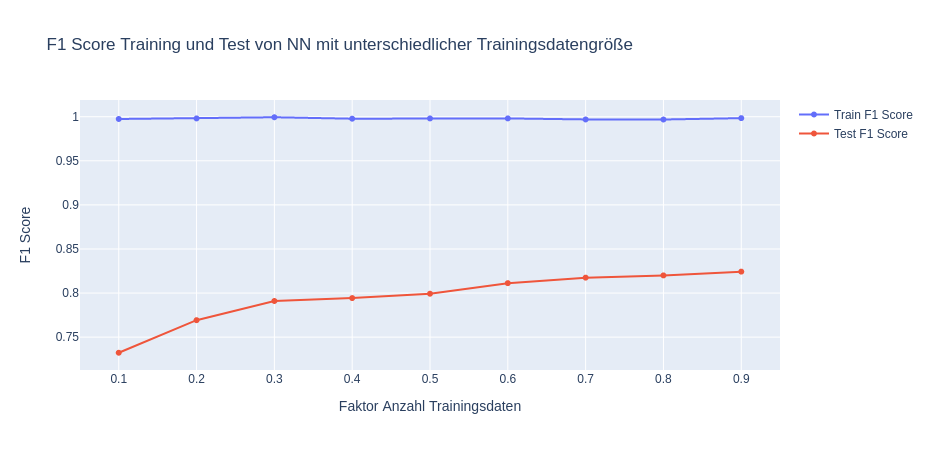

In [36]:
import tensorflow as tf
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objects as go

X_min_max = MinMaxScaler().fit_transform(X)

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(X.shape[1],)),
    tf.keras.layers.Dense(X.shape[1], activation="relu"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(150, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(80, activation="relu"),
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

es = tf.keras.callbacks.EarlyStopping(monitor="sparse_categorical_accuracy", mode="max", patience=15, restore_best_weights=True, verbose=1)

train_sizes = []
train_scores_mean = []
test_scores_mean = []

train_size_factors = np.linspace(0.1, 0.9, 9)

for size in train_size_factors:
    
    train_sizes.append(int(X.shape[0] * size))
    
    test_scores_fold = []
    train_scores_fold = []

    for train_index, test_index in StratifiedShuffleSplit(n_splits=5, train_size=size, random_state=42).split(X_min_max, y):
        f1_scores = []

        X_train, X_test = X_min_max[train_index], X_min_max[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model = tf.keras.models.clone_model(model)

        model.compile(
          optimizer=tf.keras.optimizers.Adamax(learning_rate=0.002, beta_1=0.9, beta_2=0.999),
          loss="sparse_categorical_crossentropy",
          metrics=["sparse_categorical_accuracy"]
        )

        model.fit(X_train,
          y_train,
          epochs=800,
          batch_size=64,
          callbacks=[es],
          verbose=0)

        y_pred_prob = model.predict_proba(X_test)
        y_pred = np.argmax(y_pred_prob, axis=1)
        test_scores_fold.append(np.mean(f1_score(y_test, y_pred, average=None)))
        
        y_pred_prob = model.predict_proba(X_train)
        y_pred = np.argmax(y_pred_prob, axis=1)
        train_scores_fold.append(np.mean(f1_score(y_train, y_pred, average=None)))

    test_scores_mean.append(np.mean(test_scores_fold))
    train_scores_mean.append(np.mean(train_scores_fold))
    
fig = go.Figure(data=[
    go.Scatter(x=train_size_factors, y=train_scores_mean, name="Train F1 Score"),
    go.Scatter(x=train_size_factors, y=test_scores_mean, name="Test F1 Score"),
])
fig.update_layout(title="F1 Score Training und Test von NN mit unterschiedlicher Trainingsdatengröße",
                   xaxis_title="Faktor Anzahl Trainingsdaten",
                   yaxis_title="F1 Score")
fig.show()

# Learn clf for deployment

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from joblib import dump
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

clf = RandomForestClassifier(max_depth=19, max_features=134, criterion="entropy", random_state=42, n_jobs=os.cpu_count())

smote = SMOTE(sampling_strategy={3:500}, k_neighbors=27, random_state=42, n_jobs=os.cpu_count())

pipeline = Pipeline([("oversampling", smote), ("clf", clf)])


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

print(f1_score(y_test, y_pred, average="macro"))

dump(clf, "../data/rf_basic.joblib") 

0.8634316878399874


['../data/rf_basic.joblib']

# Evaluate best Model against Botometer

In [2]:
import csv
import numpy as np

botometer_clfs_universal = {}

with open("../../datasets/botometer_clf.csv", "r") as f:
    reader = csv.reader(f)
    next(reader)

    for r in reader:
        botometer_clfs_universal[int(r[0])] = float(r[2])

dataset = np.load("../../datasets/features/twitter_bot_dataset_features_botometer_eval.npz", allow_pickle=True)
X_train = dataset["X_train"]
X_test = dataset["X_test"]

y_train = dataset["y_train"]
y_test = dataset["y_test"]

ids_train = dataset["ids_train"]
ids_test = dataset["ids_test"]
    
print("Test on total {} accounts".format(y_test.shape[0]))
test_dist = np.unique(y_test, return_counts=True)
for i, l in enumerate(label_names):
    print(l, test_dist[1][i])

# make binary clf output    
y_test_orig_label = np.copy(y_test)
y_test[y_test != label_names.index("human")] = 1
y_test[y_test == label_names.index("human")] = 0

Test on total 6226 accounts
content 215
fake_follower 127
feed 162
game 16
human 3042
political 67
service 54
social_spam 827
stock 1379
traditional_spam 337


AUC ROC (bot or human): 0.9054319923086834


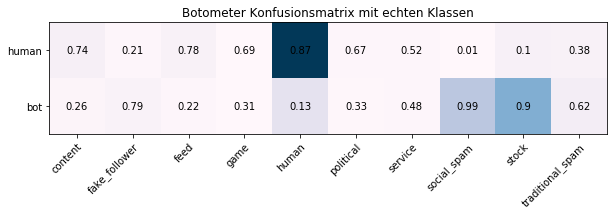

In [3]:
# from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OneHotEncoder

y_botometer_pred_prob = np.zeros((y_test.shape[0], 2))

# filter accounts which are classified by botometer
for i, user_id in enumerate(ids_test):
    bot_score = botometer_clfs_universal[user_id]
    y_botometer_pred_prob[i][0] = 1 - bot_score
    y_botometer_pred_prob[i][1] = bot_score
         
# column 0: human
# column 1: bot
y_test_oh = OneHotEncoder().fit_transform(y_test.reshape(-1,1)).toarray()
        
print("AUC ROC (bot or human): {}".format(roc_auc_score(y_test_oh, y_botometer_pred_prob)))

y_botometer_pred = np.argmax(y_botometer_pred_prob, axis=1)

conf_matrix_botom = np.zeros((2, len(label_names)))

for i, l in enumerate(y_test_orig_label):
    conf_matrix_botom[y_botometer_pred[i]][l] += 1

pred_labels = ["human", "bot"]

fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(conf_matrix_botom, cmap=plt.cm.PuBu)

ax.set_xticks(np.arange(len(label_names)))
ax.set_yticks(np.arange(len(pred_labels)))
ax.set_xticklabels(label_names)
ax.set_yticklabels(pred_labels)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

for i in range(len(pred_labels)):
    for j in range(len(label_names)):
        text = ax.text(j, i, np.true_divide(conf_matrix_botom, conf_matrix_botom.sum(axis=0, keepdims=True)).round(2)[i, j],
                       ha="center", va="center", color="black")

ax.set_title("Botometer Konfusionsmatrix mit echten Klassen")
plt.show()

0.9973948525087635


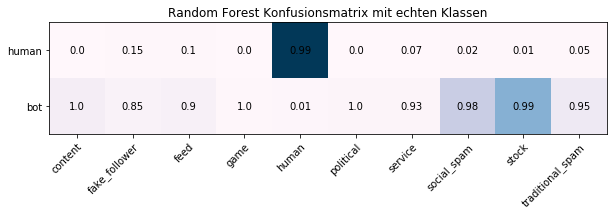

In [4]:
from mlxtend.plotting import plot_confusion_matrix
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import os

clf = RandomForestClassifier(max_depth=19, max_features=134, criterion="entropy", random_state=42, n_jobs=os.cpu_count())

smote = SMOTE(sampling_strategy={3:500}, k_neighbors=27, random_state=42, n_jobs=os.cpu_count())

pipeline = Pipeline([("smote", smote), ("clf", clf)])

pipeline.fit(X_train, y_train)

y_pred_prob = pipeline.predict_proba(X_test)


# column 0: bot
# column 1: human
y_test_oh = OneHotEncoder().fit_transform(y_test.reshape(-1,1)).toarray()
    
y_pred_prob_2 = np.zeros((y_pred_prob.shape[0], 2))
        
y_pred_prob_2[:,0] = y_pred_prob[:,label_names.index("human")]
        
y_pred_prob_2[:,1] = y_pred_prob[:, [i for i, n in enumerate(label_names) if n != "human"]].sum(axis=1)
        
print(roc_auc_score(y_test_oh, y_pred_prob_2))

y_pred = np.argmax(y_pred_prob, axis=1)

conf_matrix_botom = np.zeros((2, len(label_names)))

y_pred = np.copy(y_pred)
y_pred[y_pred != label_names.index("human")] = 1
y_pred[y_pred == label_names.index("human")] = 0

for i, l in enumerate(y_test_orig_label):
    conf_matrix_botom[y_pred[i]][l] += 1

pred_labels = ["human", "bot"]

fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(conf_matrix_botom, cmap=plt.cm.PuBu)

ax.set_xticks(np.arange(len(label_names)))
ax.set_yticks(np.arange(len(pred_labels)))
ax.set_xticklabels(label_names)
ax.set_yticklabels(pred_labels)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

for i in range(len(pred_labels)):
    for j in range(len(label_names)):
        text = ax.text(j, i, np.true_divide(conf_matrix_botom, conf_matrix_botom.sum(axis=0, keepdims=True)).round(2)[i, j],
                       ha="center", va="center", color="black")

ax.set_title("Random Forest Konfusionsmatrix mit echten Klassen")
plt.show()